## Read depth model
Modeled as zero inflated negative binomial distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.stats import betabinom
import numpy as np
from scipy.special import logsumexp
from collections import Counter

In [3]:
sample = "mm34"

reference = pd.read_csv(rf'../data/input_data/{sample}/ref.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt.csv', index_col=0)
coverage = reference.fillna(0) + alternative.fillna(0)
vaf = alternative/(alternative+reference).fillna(0)

In [4]:
def sample_zinb(mu, theta, pi, size):
    """
    Samples synthetic data from the learned ZINB distribution.
    
    Args:
        mu: Mean of the Negative Binomial.
        theta: Dispersion parameter of the Negative Binomial.
        pi: Zero-inflation probability.
        size: Number of samples to generate.
    
    Returns:
        A numpy array of sampled data.
    """
    nb_samples = nbinom.rvs(theta, theta / (theta+ mu), size=size)
    zero_inflation_mask = np.random.rand(size) < pi
    samples = np.where(zero_inflation_mask, 0, nb_samples)
    return samples

# learned from mm34 scRNA seq dataset
mu, theta, pi = 60, 0.17, 0.38
synthetic_data = sample_zinb(mu, theta, pi, size=10000)

We have to deal with a very large proportion of zero read depths

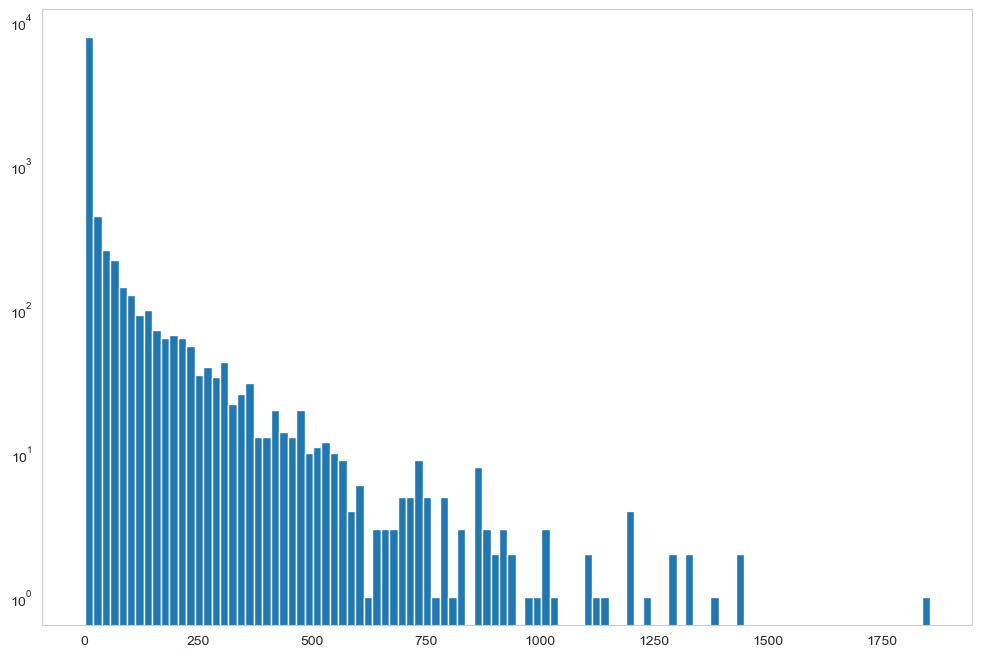

In [5]:
plt.figure(figsize=(12, 8))
plt.hist(synthetic_data, bins=100)
plt.yscale('log')
plt.grid(False)
plt.show()

## VAF simulation

1. Homozygous alternative genotype
2. Homozygous reference genotype
3. Heterozygous genotype

1. Homozygous reference genotype

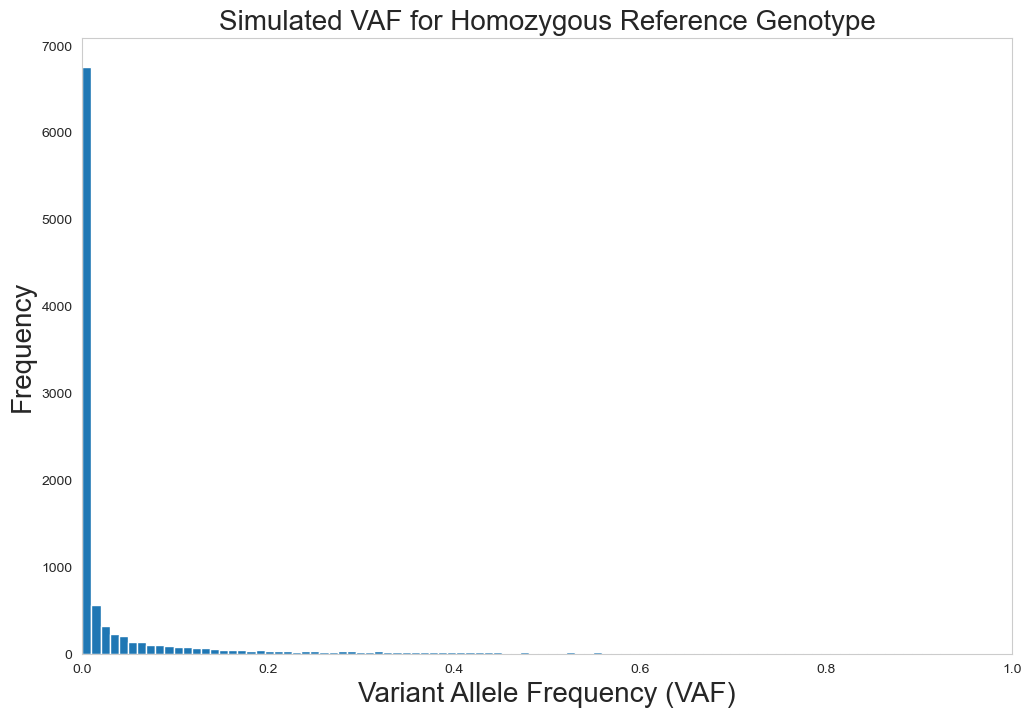

In [6]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = error_rate * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Reference Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

2. Homozygous alternative genotype

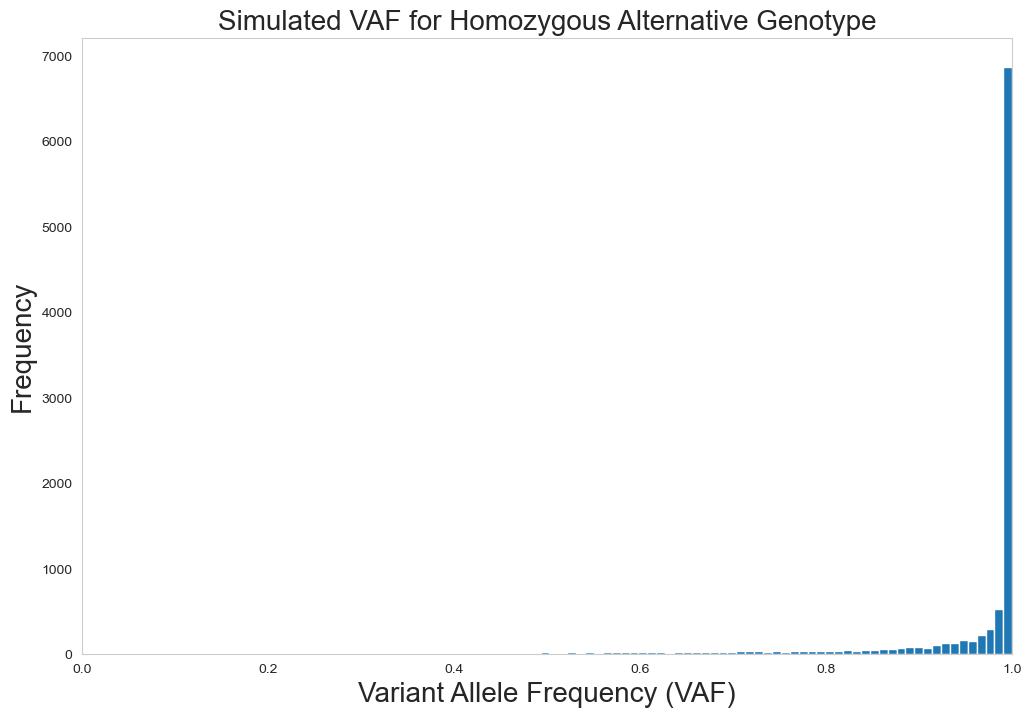

In [7]:
N = 1000  # Read depth
overdispersion = 2 # Should be learned
error_rate = 0.05  # Sequencing error rate (learned?)
alpha = (1-error_rate) * overdispersion
beta = overdispersion - alpha

# Generate simulated data for VAF using Beta-Binomial
simulated_vaf = betabinom.rvs(N, alpha, beta, size=10000) / N  # Scale by N to get VAFs

plt.figure(figsize=(12, 8))
plt.hist(simulated_vaf, bins=100)
plt.title("Simulated VAF for Homozygous Alternative Genotype", fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.xlim([0, 1])
plt.grid(False)
plt.show()

3. Heterozygous genotype

Technical dropout

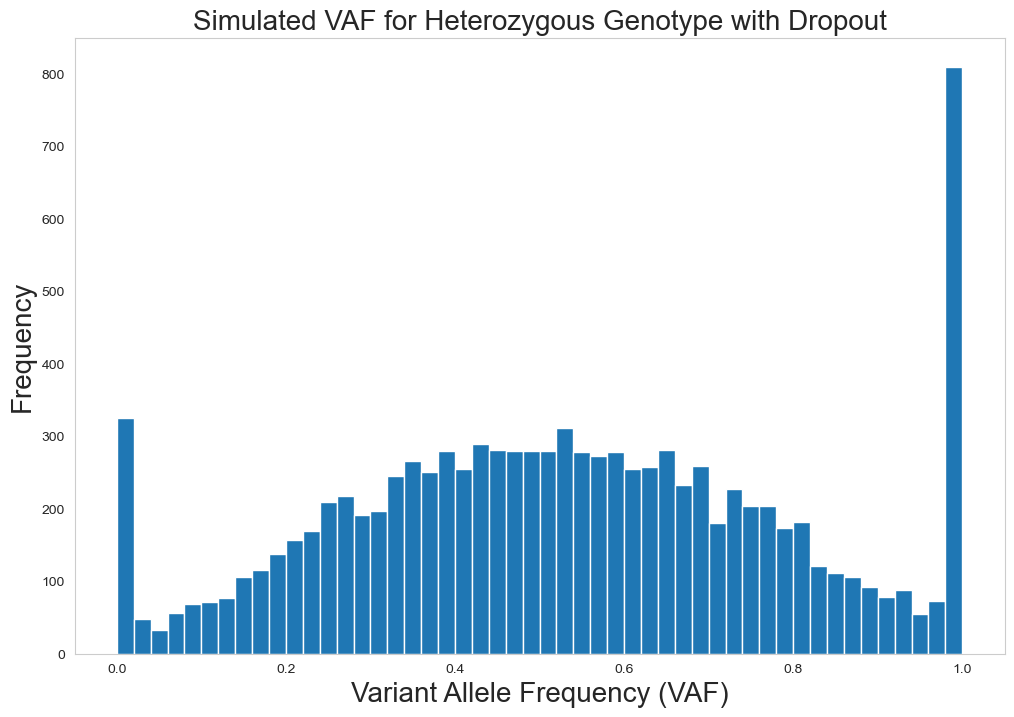

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom, bernoulli

def simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion, dropout_alpha=2, dropout_beta=8, dropout_dir_alpha=4, dropout_dir_beta=4):
    """
    Simulates VAF counts for a heterozygous genotype considering dropout and overdispersion.
    
    Parameters:
    - alpha: Shape parameter of the Beta distribution.
    - beta: Shape parameter of the Beta distribution.
    - dropout_prob: Probability of a technical dropout.
    - dropout_direction_prob: Probability the dropout favors the reference allele.
    - N: Read depth
    - num_simulations: Number of VAF simulations.
    - error_rate: Error rate for monoallelic expressed genes
    - overdispersion: Overdispersion parameter for monoallelic expressed genes
    
    
    Returns:
    - vaf_counts: Array of simulated VAF counts (variant reads).
    """
    vaf_counts = []
    
    for _ in range(num_simulations):
        # Check if a dropout occurs
        
        # dropout_prob = np.random.beta(dropout_alpha, dropout_beta) # samples the dropout rate
        # dropout_direction = np.random.beta(dropout_dir_alpha, dropout_dir_beta) # samples how imbalanced the dropout is between the alleles

        # Determine if dropout occurs
        dropout_occurs = np.random.rand() < dropout_prob

        if dropout_occurs:
            # Determine dropout direction based on sampled probabilities
            dropout_to_A = np.random.rand() < dropout_direction_prob
        
            if dropout_to_A:
                alpha_seq = (1-error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = 0
            else:
                alpha_seq = (error_rate) * overdispersion
                beta_seq = overdispersion - alpha_seq
                alt_reads = betabinom.rvs(N, alpha_seq, beta_seq)
                # alt_reads = N
        
        else:
            # No dropout: use Beta-Binomial distribution to simulate alt reads
            alt_reads = betabinom.rvs(N, alpha, beta)
        
        vaf_counts.append(alt_reads) 
         
    vaf_counts = np.array(vaf_counts)/N
    
    return vaf_counts

# Parameters
alpha = 2.5               # Beta distribution alpha parameter
beta = 2.5               # Beta distribution beta parameter
dropout_prob = 0.15      # Probability of a technical dropout
dropout_direction_prob = 0.7  # Probability dropout favors reference allele
error_rate = 0.05       # Sequencing error rate
overdispersion = 2      # Overdispersion of sequencing errors.
N = 300                 # Read depth
num_simulations = 10000 # Number of simulations

# Simulate VAF counts
vaf_counts = simulate_vaf_counts(alpha, beta, dropout_prob, dropout_direction_prob, N, num_simulations, error_rate, overdispersion)

plt.figure(figsize=(12, 8))
plt.hist(vaf_counts, bins=50)
plt.title("Simulated VAF for Heterozygous Genotype with Dropout",  fontsize=20)
plt.xlabel("Variant Allele Frequency (VAF)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.grid(False)

plt.show()

Ground Truth Parameters:
f_AA: 0.6000, f_Aa: 0.3000, f_aa: 0.1000
Simulated Read Counts: Counter({'AA': 599, 'Aa': 305, 'aa': 96})

Estimated Parameters:
f_AA: 0.6008, f_Aa: 0.3044, f_aa: 0.0948
Observed Read Counts: Counter({0: 562, 1: 356, 2: 82})


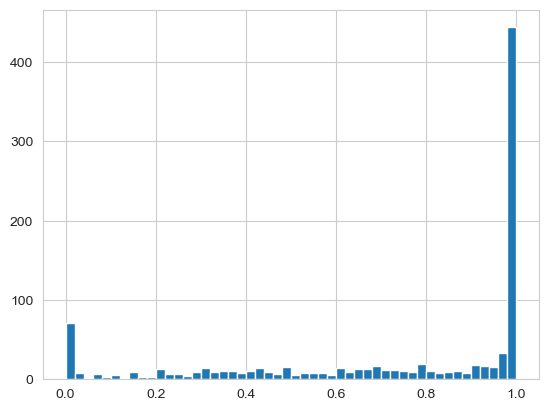

In [9]:
def beta_binomial_params(overdispersion, error_rate, genotype):
    """
    Computes the Beta-Binomial parameters for a given genotype.
    """
    if genotype == "AA":  # Homozygous reference
        alpha = (1 - error_rate) * overdispersion
        beta = overdispersion - alpha
    elif genotype == "aa":  # Homozygous alternative
        alpha = error_rate * overdispersion
        beta = overdispersion - alpha
    return alpha, beta

def genotype_probability(k, N, overdispersion, error_rate, genotype, alpha_h, beta_h):
    """
    Computes the probability of observing `k` alternative reads given genotype.
    """
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    return betabinom.pmf(k, N, alpha, beta)

def e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h):
    """
    E-Step: Computes the responsibilities for each genotype given observations.
    """
    responsibilities = []
    for k, n in zip(k_obs, N):
        # Compute unnormalized posterior probabilities for each genotype
        log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
        log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
        log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
        
        # Use log-sum-exp trick for numerical stability
        log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
        
        # Compute responsibilities
        resp_AA = np.exp(log_p_AA - log_total)
        resp_Aa = np.exp(log_p_Aa - log_total)
        resp_aa = np.exp(log_p_aa - log_total)
        
        responsibilities.append([resp_AA, resp_Aa, resp_aa])
    
    return np.array(responsibilities)

def m_step(responsibilities):
    """
    M-Step: Updates genotype frequencies based on responsibilities.
    """
    f_AA = np.mean(responsibilities[:, 0])
    f_Aa = np.mean(responsibilities[:, 1])
    f_aa = np.mean(responsibilities[:, 2])
    return f_AA, f_Aa, f_aa

def em_algorithm_fixed_params(k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h, min_iterations=10, max_iterations=100, tolerance=1e-6):
    """
    Runs the EM algorithm to estimate genotype proportions with fixed parameters.
    """
    f_AA, f_Aa, f_aa = f_AA_init, f_Aa_init, f_aa_init
    prev_log_likelihood = None
    
    for iteration in range(max_iterations):
        # E-Step
        responsibilities = e_step(k_obs, N, f_AA, f_Aa, f_aa, overdispersion, error_rate, alpha_h, beta_h)
        
        # M-Step
        f_AA, f_Aa, f_aa = m_step(responsibilities)
        
        # Compute log-likelihood for convergence check
        log_likelihood = 0
        for k, n, resp in zip(k_obs, N, responsibilities):
            log_p_AA = np.log(f_AA) + np.log(genotype_probability(k, n, overdispersion, error_rate, "AA", alpha_h, beta_h))
            log_p_Aa = np.log(f_Aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "Aa", alpha_h, beta_h))
            log_p_aa = np.log(f_aa) + np.log(genotype_probability(k, n, overdispersion, error_rate, "aa", alpha_h, beta_h))
            log_total = logsumexp([log_p_AA, log_p_Aa, log_p_aa])
            log_likelihood += log_total
        
        # Check convergence
        if iteration >= min_iterations:  # Only check convergence after min_iterations
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tolerance:
                break
        
        prev_log_likelihood = log_likelihood
    
    return f_AA, f_Aa, f_aa, responsibilities

# Parameters
np.random.seed(42)
num_simulations = 1000
overdispersion = 2
error_rate = 0.05
alpha_h, beta_h = 2, 2  # Heterozygous Beta-Binomial parameters
f_AA_true, f_Aa_true, f_aa_true = 0.6, 0.3, 0.1

# Simulate varying read depths
N = np.random.randint(500, 1500, size=num_simulations)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=num_simulations, p=[f_AA_true, f_Aa_true, f_aa_true])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))

# Run EM algorithm with fixed parameters
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3
f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs, N, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)

# Observed read counts
observed_counts = Counter(np.argmax(responsibilities, axis=1))
total_simulations = sum(observed_counts.values())

# Results
print("Ground Truth Parameters:")
print(f"f_AA: {f_AA_true:.4f}, f_Aa: {f_Aa_true:.4f}, f_aa: {f_aa_true:.4f}")
print(f"Simulated Read Counts: {read_counts}")
print("\nEstimated Parameters:")
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")
print(f"Observed Read Counts: {observed_counts}")

plt.hist(k_obs/N, bins=50)
plt.show()

f_AA: 0.5084, f_Aa: 0.1861, f_aa: 0.3055


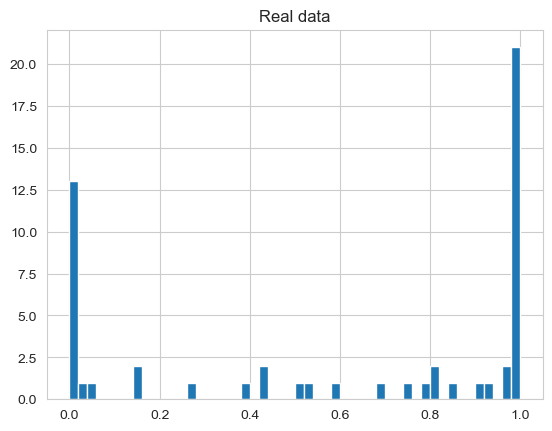

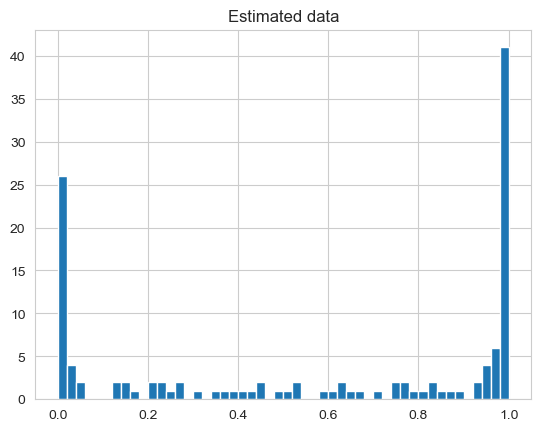

In [10]:
f_AA_init, f_Aa_init, f_aa_init = 1/3, 1/3, 1/3

non_zero_indices = np.where(coverage.iloc[:, 0] > 0)[0]
N_nonzero = np.array(coverage)[:, 0][non_zero_indices]
k_obs_nonzero = np.array(alternative)[:, 0][non_zero_indices]

f_AA_est, f_Aa_est, f_aa_est, responsibilities = em_algorithm_fixed_params(
    k_obs_nonzero, N_nonzero, f_AA_init, f_Aa_init, f_aa_init, overdispersion, error_rate, alpha_h, beta_h
)
print(f"f_AA: {f_AA_est:.4f}, f_Aa: {f_Aa_est:.4f}, f_aa: {f_aa_est:.4f}")

n_cells = 127
N = np.random.randint(500, 1500, size=n_cells)  # Variable read depths

# Generate simulated data
genotypes = np.random.choice(["AA", "Aa", "aa"], size=n_cells, p=[f_AA_est, f_Aa_est, f_aa_est])
k_obs = []
read_counts = Counter(genotypes)
for genotype, n in zip(genotypes, N):
    if genotype == "Aa":
        alpha, beta = alpha_h, beta_h
    else:
        alpha, beta = beta_binomial_params(overdispersion, error_rate, genotype)
    k_obs.append(betabinom.rvs(n, alpha, beta))
    
plt.hist(vaf.iloc[:, 0], bins=50)
plt.title("Real data")
plt.show()

plt.hist(k_obs/N, bins=50)
plt.title("Estimated data")
plt.show()

In [14]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import yaml
from src_python.noise_mutation_filter import MutationFilter
from src_python.swap_optimizer import SwapOptimizer

with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

seed = config["random_seed"]
np.random.seed(seed)

import numpy as np

def create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix, flipped):
    n_cells = mutation_matrix.shape[0]
    n_loci = len(selected) + len(not_selected_genotypes)
    genotype_matrix = np.full((n_cells, n_loci), "", dtype="str")

    not_selected = [i for i in range(n_loci) if i not in selected]

    # Assign genotypes for loci not selected for tree learning
    for n, locus in enumerate(not_selected):
        genotype_matrix[:, locus] = not_selected_genotypes[n]

    # Assign genotypes for loci selected for tree learning
    for n, locus in enumerate(selected):
        if flipped[n]:
            genotype_matrix[:, locus] = np.where(
                mutation_matrix[:, n] == 0, gt2[n],
                np.where(mutation_matrix[:, n] == 1, gt1[n], mutation_matrix[:, n])
            )
        else:
            genotype_matrix[:, locus] = np.where(
                mutation_matrix[:, n] == 0, gt1[n],
                np.where(mutation_matrix[:, n] == 1, gt2[n], mutation_matrix[:, n])
            )

    return genotype_matrix

def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_cells = len(parent_vector)
    n_leaves = int((n_cells+1)/2)
    n_mutations = len(mutation_indices)

    # Initialize mutation matrix with zeros
    mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)

    # Mark cells with mutations
    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves]

path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\100c50m"

optimizer = SwapOptimizer(spaces = ["c", "m"], reverse_mutations=True)
total_rounds = 3
n_samples = 100

error_rate = config["error_rate"]
overdispersion=config["overdispersion"]
genotype_freq=config["genotype_freq"] 
mut_freq=config["mut_freq"]
alpha_h=config["alpha_h"]
beta_h=config["beta_h"]
dropout_prob=config["dropout_prob"]
dropout_direction_prob=config["dropout_direction_prob"]
dropout_alpha = config["dropout_alpha"]
dropout_beta = config["dropout_beta"]
dropout_dir_alpha = config["dropout_dir_alpha"]
dropout_dir_beta = config["dropout_dir_beta"]

all_params = []
all_individual_params = []
all_individual_genotypes = []

for i in tqdm(range(n_samples)):
    
    all_params_i = []
    
    alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
    ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
    genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
    dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
    dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))
    alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
    betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
        
    total = ref + alt
    n_snvs = total.shape[1]
    individual_dropout_probs = np.ones(n_snvs, dtype=float) * dropout_alpha/(dropout_alpha+dropout_beta)
    individual_dropout_direction_probs = np.ones(n_snvs, dtype=float) * dropout_dir_alpha/(dropout_dir_alpha+dropout_dir_beta)
    individual_alphas_h = np.ones(n_snvs, dtype=float) * alpha_h
    individual_betas_h = np.ones(n_snvs, dtype=float) * beta_h
    
        
    for round in range(total_rounds):
        mf = MutationFilter(error_rate= error_rate, overdispersion=overdispersion,
                            genotype_freq=genotype_freq, mut_freq=mut_freq,
                            alpha_h=alpha_h, beta_h=beta_h, dropout_alpha=dropout_alpha, dropout_beta=dropout_beta, dropout_dir_alpha=dropout_dir_alpha, dropout_dir_beta=dropout_dir_beta)
        selected, gt1, gt2, not_selected_genotypes = mf.filter_mutations(ref, alt, method='first_k', n_exp=100, t=0.5) 
        llh_1, llh_2 = mf.get_llh_mat(ref[:, selected], alt[:, selected], gt1, gt2, individual=True, dropout_probs=individual_dropout_probs, dropout_direction_probs=individual_dropout_direction_probs, alphas_h=individual_alphas_h, betas_h=individual_betas_h)
    
        optimizer.fit_llh(llh_1, llh_2)
        optimizer.optimize()
        mutation_matrix = create_mutation_matrix(optimizer.ct.parent_vec, optimizer.ct.mut_loc, optimizer.ct)
        flipped = optimizer.ct.flipped
        genotype = create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix, flipped)

        vaf_error = np.sum(genotype != genotype_gt)
        print(vaf_error)
        all_individual_params.append([individual_dropout_probs, dropout_probs_gt, individual_dropout_direction_probs, dropout_directions_gt, individual_alphas_h, alphas_H_gt, individual_betas_h, betas_H_gt])
        all_individual_genotypes.append([genotype_gt, genotype])

        params = mf.update_parameters(np.array(ref), np.array(alt), np.array(genotype))
        
        dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, individual_dropout_probs, individual_dropout_direction_probs, individual_alphas_h, individual_betas_h = params

        all_params_i.append([dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, vaf_error])
        print(f"Round {round} ")
    all_params.append(all_params_i)

  0%|          | 0/100 [00:00<?, ?it/s]

Optimizing cell lineage tree ...
-3901.512481718836 -3895.3881012199236
Optimizing mutation tree ...
after Node reattachment  -3889.236239799895
-3885.4311427414327 -3885.4311427414327
Optimizing cell lineage tree ...
-3885.4311427414327 -3885.4311427414323
Optimizing mutation tree ...
after Node reattachment  -3884.0496754640603
-3883.195404703254 -3883.195404703254
Optimizing cell lineage tree ...
-3883.195404703254 -3883.195404703254
Optimizing mutation tree ...
after Node reattachment  -3883.195404703254
-3883.195404703254 -3883.195404703254
350
optimized:  3845.9313296023665
ground truth:  3885.0653808461075
Global parameters: [ 0.07600284  0.50859127 11.22512422  0.04406745  6.69673071]
Round 0 
Optimizing cell lineage tree ...
-3892.4077019946785 -3891.0399676554644
Optimizing mutation tree ...
after Node reattachment  -3881.1479742438137
-3875.405333123477 -3875.8949918160865
Optimizing cell lineage tree ...
-3874.5921642310964 -3874.592164231096
Optimizing mutation tree ...
af

  1%|          | 1/100 [00:26<44:09, 26.76s/it]

Round 2 
Optimizing cell lineage tree ...
-4236.474125620818 -4234.096692950519
Optimizing mutation tree ...
after Node reattachment  -4228.071677297221
-4223.077290296629 -4223.077290296629
Optimizing cell lineage tree ...
-4220.983074000505 -4220.983074000505
Optimizing mutation tree ...
after Node reattachment  -4220.269008335788
-4218.849595849245 -4218.849595849246
Optimizing cell lineage tree ...
-4216.446470708454 -4216.446470708455
Optimizing mutation tree ...
after Node reattachment  -4216.446470708455
-4216.446470708454 -4216.446470708455
Optimizing cell lineage tree ...
-4216.446470708454 -4216.446470708455
389
optimized:  4196.056716964834
ground truth:  4218.316446851307
Global parameters: [ 0.11056387  0.28179534 12.25284696  0.04447445  5.64731943]
Round 0 
Optimizing cell lineage tree ...
-4241.948028088448 -4228.021136029709
Optimizing mutation tree ...
after Node reattachment  -4212.633288827772
-4206.728142799671 -4210.017663167553
Optimizing cell lineage tree ...
-4

  2%|▏         | 2/100 [00:47<38:07, 23.34s/it]

Round 2 
Optimizing cell lineage tree ...
-4585.54594293127 -4579.648350230938
Optimizing mutation tree ...
after Node reattachment  -4570.442973747536
-4569.391575494926 -4569.391575494926
Optimizing cell lineage tree ...
-4568.310581679326 -4568.310581679327
Optimizing mutation tree ...
after Node reattachment  -4567.646578896312
-4566.502431961532 -4566.502431961533
Optimizing cell lineage tree ...
-4566.502431961532 -4566.502431961533
Optimizing mutation tree ...
after Node reattachment  -4566.502431961533
-4566.502431961532 -4566.502431961533
397
optimized:  4540.5839978885515
ground truth:  4568.372408104377
Global parameters: [ 0.12744258  0.67640168 11.90088889  0.04643339  6.38381648]
Round 0 
Optimizing cell lineage tree ...
-4581.325136973383 -4576.931404535237
Optimizing mutation tree ...
after Node reattachment  -4561.923745190605
-4560.263383552564 -4560.263383552564
Optimizing cell lineage tree ...
-4559.915729608934 -4559.915729608936
Optimizing mutation tree ...
after 

  3%|▎         | 3/100 [01:07<35:21, 21.88s/it]

Round 2 
Optimizing cell lineage tree ...
-4094.7207156872673 -4087.636246448521
Optimizing mutation tree ...
after Node reattachment  -4083.2541182043497
-4079.140968874769 -4079.140968874769
Optimizing cell lineage tree ...
-4078.544899930251 -4078.287731708423
Optimizing mutation tree ...
after Node reattachment  -4078.287731708423
-4078.170475180811 -4078.170475180811
Optimizing cell lineage tree ...
-4077.92922759635 -4077.92922759635
Optimizing mutation tree ...
after Node reattachment  -4076.9948124346165
-4076.994812434617 -4076.9948124346165
Optimizing cell lineage tree ...
-4076.994812434617 -4076.9948124346165
Optimizing mutation tree ...
after Node reattachment  -4076.9948124346165
-4076.994812434617 -4076.9948124346165
365
optimized:  4054.0895333164785
ground truth:  4078.8647885774712
Global parameters: [ 0.12739204  0.32075254 10.96369258  0.04263276  6.2345857 ]
Round 0 
Optimizing cell lineage tree ...
-4082.9596561059097 -4077.8471640388093
Optimizing mutation tree .

  4%|▍         | 4/100 [01:36<39:27, 24.66s/it]

Round 2 
Optimizing cell lineage tree ...
-4324.4153932348545 -4322.374583051835
Optimizing mutation tree ...
after Node reattachment  -4313.967946912552
-4309.820754217114 -4309.820754217115
Optimizing cell lineage tree ...
-4308.970140373689 -4308.97014037369
Optimizing mutation tree ...
after Node reattachment  -4308.97014037369
-4308.970140373689 -4308.97014037369
Optimizing cell lineage tree ...
-4308.970140373689 -4308.970140373689
412
optimized:  4275.760523004363
ground truth:  4310.840116516538
Global parameters: [ 0.10763171  0.48758649 10.02951784  0.04468436  6.07210459]
Round 0 
Optimizing cell lineage tree ...
-4312.083741345142 -4303.685696458533
Optimizing mutation tree ...
after Node reattachment  -4291.6582428597485
-4291.051747148889 -4291.051747148887
Optimizing cell lineage tree ...
-4289.938718705108 -4289.938718705107
Optimizing mutation tree ...
after Node reattachment  -4289.938718705107
-4289.100956420398 -4289.186531203881
Optimizing cell lineage tree ...
-42

  5%|▌         | 5/100 [02:03<40:07, 25.35s/it]

Round 2 
Optimizing cell lineage tree ...
-4247.11969735856 -4242.008935841457
Optimizing mutation tree ...
after Node reattachment  -4237.37144204367
-4237.065030371702 -4237.065030371703
Optimizing cell lineage tree ...
-4234.933981007479 -4234.933981007478
Optimizing mutation tree ...
after Node reattachment  -4234.661807865028
-4234.661807865028 -4234.661807865028
Optimizing cell lineage tree ...
-4234.661807865028 -4234.661807865028
Optimizing mutation tree ...
after Node reattachment  -4234.661807865028
-4234.661807865028 -4234.661807865028
371
optimized:  4195.457111377247
ground truth:  4236.531784007889
Global parameters: [ 0.10399337  0.35261384 11.27848194  0.04403822  7.01972113]
Round 0 
Optimizing cell lineage tree ...
-4246.661712578803 -4241.4554704649345
Optimizing mutation tree ...
after Node reattachment  -4227.771277152763
-4221.7080013798195 -4221.70800137982
Optimizing cell lineage tree ...
-4220.555508935223 -4220.555508935224
Optimizing mutation tree ...
after N

  6%|▌         | 6/100 [02:29<40:17, 25.72s/it]

Round 2 
Optimizing cell lineage tree ...
-4097.696679347013 -4096.7720918921605
Optimizing mutation tree ...
after Node reattachment  -4094.1063356602745
-4086.580489512857 -4087.195688583156
Optimizing cell lineage tree ...
-4082.4241358848562 -4082.4241358848567
Optimizing mutation tree ...
after Node reattachment  -4082.161087511558
-4082.0255735279916 -4082.0255735279916
Optimizing cell lineage tree ...
-4082.0255735279916 -4082.0255735279916
Optimizing mutation tree ...
after Node reattachment  -4082.0255735279916
-4082.0255735279916 -4082.0255735279916
375
optimized:  4039.6214689964836
ground truth:  4083.895549670845
Global parameters: [ 0.10324854  0.7413687  12.09000366  0.04215315  7.44074205]
Round 0 
Optimizing cell lineage tree ...
-4088.2561575363657 -4083.468288356963
Optimizing mutation tree ...
after Node reattachment  -4072.941390778391
-4062.1053642378088 -4062.5912275746523
Optimizing cell lineage tree ...
-4060.3037700092727 -4060.3037700092727
Optimizing mutatio

  7%|▋         | 7/100 [02:51<37:58, 24.50s/it]

Round 2 
Optimizing cell lineage tree ...
-4002.3096573171215 -4000.320611728828
Optimizing mutation tree ...
after Node reattachment  -3995.8558981840106
-3995.3984465054014 -3995.398446505402
Optimizing cell lineage tree ...
-3991.9588160513695 -3991.95881605137
Optimizing mutation tree ...
after Node reattachment  -3991.8894621316263
-3991.889462131626 -3991.8894621316263
Optimizing cell lineage tree ...
-3991.8655584244675 -3991.865558424467
Optimizing mutation tree ...
after Node reattachment  -3991.357301490364
-3991.3573014903636 -3991.357301490364
Optimizing cell lineage tree ...
-3990.6434520772405 -3990.643452077241
Optimizing mutation tree ...
after Node reattachment  -3990.6111534531456
-3990.2738044426087 -3990.273804442609
Optimizing cell lineage tree ...
-3990.273804442609 -3990.2738044426087
Optimizing mutation tree ...
after Node reattachment  -3990.0914726473284
-3990.091472647329 -3990.0914726473284
Optimizing cell lineage tree ...
-3990.091472647329 -3990.0914726473

  8%|▊         | 8/100 [03:14<36:36, 23.88s/it]

Round 2 
Optimizing cell lineage tree ...
-4607.441014591913 -4602.154986736096
Optimizing mutation tree ...
after Node reattachment  -4590.524713076827
-4588.372620299418 -4588.3726202994185
Optimizing cell lineage tree ...
-4588.304097546802 -4588.304097546802
Optimizing mutation tree ...
after Node reattachment  -4584.273571777565
-4583.100689943071 -4583.100689943072
Optimizing cell lineage tree ...
-4580.588124307597 -4580.588124307599
Optimizing mutation tree ...
after Node reattachment  -4580.588124307599
-4580.588124307597 -4580.588124307599
Optimizing cell lineage tree ...
-4580.588124307597 -4580.588124307598
390
optimized:  4544.913564613225
ground truth:  4582.458100450444
Global parameters: [ 0.10484494  0.53564797 10.44367104  0.04571281  6.45526008]
Round 0 
Optimizing cell lineage tree ...
-4572.738541586499 -4567.161167680961
Optimizing mutation tree ...
after Node reattachment  -4561.689630363248
-4560.109349481105 -4560.109349481106
Optimizing cell lineage tree ...
-

  9%|▉         | 9/100 [03:37<35:59, 23.74s/it]

Round 2 
Optimizing cell lineage tree ...
-3761.941683445723 -3758.304990030657
Optimizing mutation tree ...
after Node reattachment  -3753.015016126076
-3749.186965505545 -3749.322479489111
Optimizing cell lineage tree ...
-3748.7264774738774 -3748.590963490311
Optimizing mutation tree ...
after Node reattachment  -3748.558985009926
-3747.0253263698924 -3747.0253263698924
Optimizing cell lineage tree ...
-3747.0253263698924 -3747.0253263698933
Optimizing mutation tree ...
after Node reattachment  -3746.3622182861154
-3746.362218286115 -3746.3622182861154
Optimizing cell lineage tree ...
-3746.362218286115 -3746.3622182861154
Optimizing mutation tree ...
after Node reattachment  -3746.3622182861154
-3746.3622182861145 -3746.3622182861154
331
optimized:  3710.833935675561
ground truth:  3748.2321944289693
Global parameters: [ 0.09490315  0.55112993 13.4646753   0.03669699  5.04427001]
Round 0 
Optimizing cell lineage tree ...
-3769.719730337746 -3764.491719448075
Optimizing mutation tre

 10%|█         | 10/100 [03:56<33:22, 22.25s/it]

Round 2 
Optimizing cell lineage tree ...
-4405.216632290186 -4400.652455752172
Optimizing mutation tree ...
after Node reattachment  -4397.393439602516
-4394.945977913068 -4395.081491896636
Optimizing cell lineage tree ...
-4394.945977913068 -4394.945977913069
Optimizing mutation tree ...
after Node reattachment  -4390.314151990188
-4390.314151990187 -4390.314151990188
Optimizing cell lineage tree ...
-4390.314151990187 -4390.314151990187
Optimizing mutation tree ...
after Node reattachment  -4390.314151990187
-4390.314151990187 -4390.314151990187
388
optimized:  4364.728985275334
ground truth:  4392.184128133039
Global parameters: [ 0.13126461  0.58129707 10.5135479   0.04539981  6.49913051]
Round 0 
Optimizing cell lineage tree ...
-4399.087365057208 -4390.051667902653
Optimizing mutation tree ...
after Node reattachment  -4380.481714244137
-4377.668518425525 -4377.668518425526
Optimizing cell lineage tree ...
-4376.817240739295 -4376.817240739296
Optimizing mutation tree ...
after 

 11%|█         | 11/100 [04:18<32:36, 21.98s/it]

Round 2 
Optimizing cell lineage tree ...
-4477.858405187491 -4472.114261661317
Optimizing mutation tree ...
after Node reattachment  -4462.617779371529
-4457.6107792771945 -4457.6107792771945
Optimizing cell lineage tree ...
-4451.144966386826 -4451.144966386825
Optimizing mutation tree ...
after Node reattachment  -4449.197658013569
-4448.735712867989 -4448.735712867988
Optimizing cell lineage tree ...
-4448.735712867989 -4448.735712867989
Optimizing mutation tree ...
after Node reattachment  -4448.735712867989
-4448.735712867989 -4448.735712867989
378
optimized:  4414.232276359545
ground truth:  4450.605689010841
Global parameters: [ 0.1303676   0.40842879 10.87060074  0.04414186  6.95450972]
Round 0 
Optimizing cell lineage tree ...
-4450.6422673715315 -4443.312757390822
Optimizing mutation tree ...
after Node reattachment  -4437.384375022582
-4436.234690958809 -4436.234690958809
Optimizing cell lineage tree ...
-4434.872902493084 -4434.872902493085
Optimizing mutation tree ...
aft

 12%|█▏        | 12/100 [04:36<30:51, 21.04s/it]

Round 2 
Optimizing cell lineage tree ...
-4573.554723160295 -4567.539476734829
Optimizing mutation tree ...
after Node reattachment  -4559.2947241782385
-4540.144701246354 -4541.402511254697
Optimizing cell lineage tree ...
-4536.270191951941 -4536.270191951941
Optimizing mutation tree ...
after Node reattachment  -4536.270191951941
-4535.365253549477 -4535.365253549477
Optimizing cell lineage tree ...
-4535.365253549477 -4535.365253549477
Optimizing mutation tree ...
after Node reattachment  -4535.365253549477
-4535.365253549477 -4535.365253549477
433
optimized:  4512.347221452773
ground truth:  4537.235229692326
Global parameters: [ 0.16425355  0.50601108 13.87556997  0.03978553  6.31892418]
Round 0 
Optimizing cell lineage tree ...
-4571.589561002428 -4559.734021974244
Optimizing mutation tree ...
after Node reattachment  -4557.540359325211
-4550.850246987648 -4550.8502469876485
Optimizing cell lineage tree ...
-4549.222069726691 -4547.98253819512
Optimizing mutation tree ...
after

 13%|█▎        | 13/100 [05:00<31:42, 21.87s/it]

Round 2 
Optimizing cell lineage tree ...
-4117.651013762831 -4114.239760387265
Optimizing mutation tree ...
after Node reattachment  -4102.446205287609
-4101.6900532050895 -4101.690053205089
Optimizing cell lineage tree ...
-4100.193863757709 -4100.193863757709
Optimizing mutation tree ...
after Node reattachment  -4099.587690669221
-4099.587690669221 -4099.587690669221
Optimizing cell lineage tree ...
-4099.482659296991 -4099.48265929699
Optimizing mutation tree ...
after Node reattachment  -4099.48265929699
-4099.482659296991 -4099.48265929699
Optimizing cell lineage tree ...
-4099.412003854749 -4099.412003854749
Optimizing mutation tree ...
after Node reattachment  -4098.439356749215
-4098.439356749215 -4098.439356749215
Optimizing cell lineage tree ...
-4098.439356749215 -4098.439356749215
Optimizing mutation tree ...
after Node reattachment  -4098.439356749215
-4098.439356749215 -4098.439356749215
394
optimized:  4068.635608325997
ground truth:  4100.309332892065
Global parameter

 14%|█▍        | 14/100 [05:25<32:44, 22.85s/it]

Round 2 
Optimizing cell lineage tree ...
-4392.414923857264 -4389.98411652665
Optimizing mutation tree ...
after Node reattachment  -4385.710500686169
-4383.224182641342 -4383.224182641342
Optimizing cell lineage tree ...
-4381.994194128659 -4381.99419412866
Optimizing mutation tree ...
after Node reattachment  -4379.424729823219
-4379.424729823219 -4379.424729823219
Optimizing cell lineage tree ...
-4377.839951098018 -4377.839951098018
Optimizing mutation tree ...
after Node reattachment  -4377.839951098018
-4377.093118435794 -4377.093118435794
Optimizing cell lineage tree ...
-4377.093118435794 -4377.093118435794
Optimizing mutation tree ...
after Node reattachment  -4377.093118435794
-4377.093118435794 -4377.093118435794
371
optimized:  4348.521636132465
ground truth:  4378.963094578645
Global parameters: [ 0.13641334  0.65785419 10.99356631  0.04603917  7.06788735]
Round 0 
Optimizing cell lineage tree ...
-4379.13234042393 -4377.77731554002
Optimizing mutation tree ...
after Node

 15%|█▌        | 15/100 [05:43<30:12, 21.32s/it]

Round 2 
Optimizing cell lineage tree ...
-4152.189947597277 -4151.17845870745
Optimizing mutation tree ...
after Node reattachment  -4147.624542629059
-4141.500850300448 -4141.50085030045
Optimizing cell lineage tree ...
-4140.109806327791 -4139.047824395619
Optimizing mutation tree ...
after Node reattachment  -4137.251353204521
-4137.25135320452 -4137.251353204521
Optimizing cell lineage tree ...
-4136.721911793453 -4136.721911793454
Optimizing mutation tree ...
after Node reattachment  -4136.721911793454
-4136.721911793453 -4136.721911793454
Optimizing cell lineage tree ...
-4136.721911793453 -4136.721911793454
435
optimized:  4112.6458816370805
ground truth:  4138.59188793631
Global parameters: [0.14682833 0.37455526 9.81040814 0.04435899 6.54197433]
Round 0 
Optimizing cell lineage tree ...
-4150.537150785345 -4146.363375206455
Optimizing mutation tree ...
after Node reattachment  -4142.275653437615
-4135.516143685916 -4135.516143685915
Optimizing cell lineage tree ...
-4130.7353

 16%|█▌        | 16/100 [06:07<31:07, 22.23s/it]

Round 2 
Optimizing cell lineage tree ...
-4463.453568831213 -4462.315587412032
Optimizing mutation tree ...
after Node reattachment  -4457.800460777084
-4457.002041425397 -4457.002041425398
Optimizing cell lineage tree ...
-4449.469128680395 -4449.469128680396
Optimizing mutation tree ...
after Node reattachment  -4448.155465051814
-4448.155465051814 -4448.155465051814
Optimizing cell lineage tree ...
-4446.866946517206 -4446.866946517206
Optimizing mutation tree ...
after Node reattachment  -4445.948575314154
-4445.948575314154 -4445.948575314154
Optimizing cell lineage tree ...
-4445.780690309073 -4445.780690309074
Optimizing mutation tree ...
after Node reattachment  -4445.731750916066
-4444.369425745057 -4444.369425745059
Optimizing cell lineage tree ...
-4444.369425745057 -4444.369425745059
Optimizing mutation tree ...
after Node reattachment  -4444.369425745059
-4444.369425745057 -4444.369425745059
466
optimized:  4421.980143465894
ground truth:  4446.239401887914
Global paramet

 17%|█▋        | 17/100 [06:32<31:46, 22.97s/it]

Round 2 
Optimizing cell lineage tree ...
-4166.855614990046 -4157.384026525913
Optimizing mutation tree ...
after Node reattachment  -4150.599834025991
-4150.256244324659 -4150.256244324659
Optimizing cell lineage tree ...
-4150.201828376124 -4150.2018283761245
Optimizing mutation tree ...
after Node reattachment  -4150.2018283761245
-4150.201828376124 -4150.2018283761245
Optimizing cell lineage tree ...
-4150.201828376124 -4150.2018283761245
380
optimized:  4109.892207123095
ground truth:  4152.071804518979
Global parameters: [ 0.11485546  0.28228784 12.53485918  0.04493605  7.9415    ]
Round 0 
Optimizing cell lineage tree ...
-4143.664351462589 -4141.108423689128
Optimizing mutation tree ...
after Node reattachment  -4136.341619287632
-4131.829177555476 -4133.481407666582
Optimizing cell lineage tree ...
-4129.844455269342 -4129.085955471144
Optimizing mutation tree ...
after Node reattachment  -4128.23078935392
-4127.876648611483 -4127.876648611483
Optimizing cell lineage tree ...

 18%|█▊        | 18/100 [06:50<29:26, 21.55s/it]

Round 2 
Optimizing cell lineage tree ...
-4375.891688089632 -4371.854809229382
Optimizing mutation tree ...
after Node reattachment  -4368.663309621432
-4365.4618283770815 -4365.677340473698
Optimizing cell lineage tree ...
-4362.064174751896 -4361.933683234917
Optimizing mutation tree ...
after Node reattachment  -4361.933683234917
-4361.933683234917 -4361.933683234917
Optimizing cell lineage tree ...
-4361.933683234917 -4361.933683234917
Optimizing mutation tree ...
after Node reattachment  -4361.933683234917
-4360.927975370277 -4360.927975370277
Optimizing cell lineage tree ...
-4360.695658613577 -4360.695658613577
Optimizing mutation tree ...
after Node reattachment  -4360.695658613577
-4360.695658613577 -4360.695658613577
Optimizing cell lineage tree ...
-4360.695658613577 -4360.695658613577
470
optimized:  4332.031664388619
ground truth:  4362.565634756431
Global parameters: [ 0.10127652  0.45684753 10.26017232  0.04711276  6.21129394]
Round 0 
Optimizing cell lineage tree ...
-

 19%|█▉        | 19/100 [07:17<31:12, 23.12s/it]

Round 2 
Optimizing cell lineage tree ...
-4296.832899423366 -4290.240152507489
Optimizing mutation tree ...
after Node reattachment  -4277.724473009381
-4276.104923163828 -4276.104923163828
Optimizing cell lineage tree ...
-4275.009805963482 -4275.009805963484
Optimizing mutation tree ...
after Node reattachment  -4275.009805963484
-4275.009805963482 -4275.009805963484
Optimizing cell lineage tree ...
-4275.009805963482 -4275.009805963484
396
optimized:  4250.0069357441835
ground truth:  4276.879782106333
Global parameters: [ 0.13068174  0.33551851 10.60803412  0.04278004  6.39152851]
Round 0 
Optimizing cell lineage tree ...
-4296.000170368659 -4289.660394982009
Optimizing mutation tree ...
after Node reattachment  -4276.380617998898
-4266.7852850135 -4268.594330913613
Optimizing cell lineage tree ...
-4263.848314185734 -4263.848314185733
Optimizing mutation tree ...
after Node reattachment  -4263.848314185733
-4263.848314185734 -4263.848314185733
Optimizing cell lineage tree ...
-42

 20%|██        | 20/100 [07:34<28:10, 21.14s/it]

Round 2 
Optimizing cell lineage tree ...
-4407.670607559495 -4400.762660594778
Optimizing mutation tree ...
after Node reattachment  -4389.264456978775
-4383.512008200038 -4383.512008200038
Optimizing cell lineage tree ...
-4380.6053750945075 -4380.315484477395
Optimizing mutation tree ...
after Node reattachment  -4378.562030224164
-4378.041749548928 -4378.041749548928
Optimizing cell lineage tree ...
-4378.041749548928 -4378.041749548929
Optimizing mutation tree ...
after Node reattachment  -4378.041749548929
-4378.041749548928 -4378.041749548929
387
optimized:  4344.996969696321
ground truth:  4379.91172569178
Global parameters: [ 0.11792765  0.2968384  13.51267933  0.04700337  6.63826131]
Round 0 
Optimizing cell lineage tree ...
-4382.787096219131 -4381.590473040136
Optimizing mutation tree ...
after Node reattachment  -4374.265383622924
-4360.2948460744365 -4361.770748396814
Optimizing cell lineage tree ...
-4359.656095650109 -4359.656095650109
Optimizing mutation tree ...
after

 21%|██        | 21/100 [07:52<26:39, 20.24s/it]

Round 2 
Optimizing cell lineage tree ...
-4437.864729666049 -4436.612591482188
Optimizing mutation tree ...
after Node reattachment  -4425.969028571832
-4422.818997881142 -4423.243049927469
Optimizing cell lineage tree ...
-4419.901168814581 -4419.901168814582
Optimizing mutation tree ...
after Node reattachment  -4418.405175399144
-4418.013648872127 -4418.405175399144
Optimizing cell lineage tree ...
-4417.880260145299 -4417.648185760304
Optimizing mutation tree ...
after Node reattachment  -4416.7928583137755
-4416.605770550046 -4416.605770550046
Optimizing cell lineage tree ...
-4416.605770550046 -4416.605770550046
Optimizing mutation tree ...
after Node reattachment  -4416.605770550046
-4416.605770550046 -4416.605770550046
373
optimized:  4390.120789290722
ground truth:  4418.475746692896
Global parameters: [ 0.10657012  0.50440506 10.17416039  0.04790349  6.20752139]
Round 0 
Optimizing cell lineage tree ...
-4419.582683437847 -4410.471731075587
Optimizing mutation tree ...
after

 22%|██▏       | 22/100 [08:11<25:58, 19.98s/it]

Round 2 
Optimizing cell lineage tree ...
-4437.0735355952165 -4428.939237727434
Optimizing mutation tree ...
after Node reattachment  -4416.924195393666
-4414.01959697695 -4414.019596976952
Optimizing cell lineage tree ...
-4413.163432812336 -4413.163432812336
Optimizing mutation tree ...
after Node reattachment  -4412.336979909915
-4410.512671717509 -4411.062350610346
Optimizing cell lineage tree ...
-4410.512671717509 -4410.51267171751
Optimizing mutation tree ...
after Node reattachment  -4408.484416154008
-4407.351258097737 -4407.351258097738
Optimizing cell lineage tree ...
-4406.882942935594 -4406.882942935594
Optimizing mutation tree ...
after Node reattachment  -4406.882942935594
-4406.882942935594 -4406.882942935594
Optimizing cell lineage tree ...
-4406.882942935594 -4406.882942935594
417
optimized:  4366.253614667002
ground truth:  4408.752919078439
Global parameters: [ 0.0851294   0.44503184 10.09507937  0.04401277  6.33599402]
Round 0 
Optimizing cell lineage tree ...
-44

 23%|██▎       | 23/100 [08:36<27:27, 21.40s/it]

Round 2 
Optimizing cell lineage tree ...
-4212.9189471551335 -4203.097044312174
Optimizing mutation tree ...
after Node reattachment  -4195.388535577369
-4194.104827805024 -4194.104827805025
Optimizing cell lineage tree ...
-4193.212260110368 -4193.212260110368
Optimizing mutation tree ...
after Node reattachment  -4192.35446106258
-4192.35446106258 -4192.35446106258
Optimizing cell lineage tree ...
-4192.35446106258 -4192.354461062581
Optimizing mutation tree ...
after Node reattachment  -4192.354461062581
-4192.35446106258 -4192.354461062581
393
optimized:  4147.888233281675
ground truth:  4194.2244372054265
Global parameters: [ 0.08601301  0.5770158  10.36520272  0.04568483  6.92242804]
Round 0 
Optimizing cell lineage tree ...
-4212.995814055824 -4204.519605972001
Optimizing mutation tree ...
after Node reattachment  -4199.765195299568
-4193.573094584103 -4193.573094584105
Optimizing cell lineage tree ...
-4187.105765222568 -4186.31862994777
Optimizing mutation tree ...
after Node

 24%|██▍       | 24/100 [08:58<27:27, 21.67s/it]

Round 2 
Optimizing cell lineage tree ...
-4433.069134912869 -4427.4762047055865
Optimizing mutation tree ...
after Node reattachment  -4419.77930839737
-4408.9087969985085 -4408.90879699851
Optimizing cell lineage tree ...
-4408.106087615437 -4408.106087615439
Optimizing mutation tree ...
after Node reattachment  -4407.074496066776
-4406.898087043912 -4406.898087043913
Optimizing cell lineage tree ...
-4399.25952364862 -4399.259523648622
Optimizing mutation tree ...
after Node reattachment  -4399.184227699092
-4397.547800301232 -4397.547800301233
Optimizing cell lineage tree ...
-4396.169206315442 -4395.784073250366
Optimizing mutation tree ...
after Node reattachment  -4393.952614902833
-4393.9526149028325 -4393.952614902833
Optimizing cell lineage tree ...
-4393.820715946953 -4393.434910759284
Optimizing mutation tree ...
after Node reattachment  -4393.434910759284
-4393.434910759283 -4393.434910759284
Optimizing cell lineage tree ...
-4393.434910759283 -4393.434910759284
Optimizing

 25%|██▌       | 25/100 [09:28<30:16, 24.23s/it]

Round 2 
Optimizing cell lineage tree ...
-4087.3774435066102 -4084.9989155264293
Optimizing mutation tree ...
after Node reattachment  -4074.424108847622
-4066.3467461168466 -4066.3690358098015
Optimizing cell lineage tree ...
-4065.1718712999154 -4065.1718712999163
Optimizing mutation tree ...
after Node reattachment  -4064.506249862464
-4063.075505509939 -4063.07550550994
Optimizing cell lineage tree ...
-4062.8880551558627 -4062.888055155863
Optimizing mutation tree ...
after Node reattachment  -4062.888055155863
-4062.8880551558627 -4062.888055155863
Optimizing cell lineage tree ...
-4062.8880551558627 -4062.888055155863
357
optimized:  4026.2870912178037
ground truth:  4064.7580312987143
Global parameters: [ 0.09396906  0.30060081 11.69628758  0.04578347  7.37715998]
Round 0 
Optimizing cell lineage tree ...
-4072.9839760209466 -4059.5780980652203
Optimizing mutation tree ...
after Node reattachment  -4054.8051186551556
-4053.51245109671 -4053.5124510967107
Optimizing cell lineag

 26%|██▌       | 26/100 [09:49<28:28, 23.09s/it]

Round 2 
Optimizing cell lineage tree ...
-4442.843089044893 -4437.512415308269
Optimizing mutation tree ...
after Node reattachment  -4429.14657064064
-4420.751814696468 -4421.709618302908
Optimizing cell lineage tree ...
-4417.3299923523255 -4417.3299923523255
Optimizing mutation tree ...
after Node reattachment  -4415.3673492832495
-4415.3673492832495 -4415.3673492832495
Optimizing cell lineage tree ...
-4414.234898526446 -4414.234898526447
Optimizing mutation tree ...
after Node reattachment  -4414.234898526447
-4414.234898526446 -4414.234898526447
Optimizing cell lineage tree ...
-4414.234898526446 -4414.234898526447
466
optimized:  4403.492961011981
ground truth:  4416.104874669303
Global parameters: [ 0.15866706  0.6058778  10.77681901  0.04675508  5.87471372]
Round 0 
Optimizing cell lineage tree ...
-4475.333036256019 -4455.5582124601315
Optimizing mutation tree ...
after Node reattachment  -4440.190602235607
-4436.104409586248 -4436.972691803272
Optimizing cell lineage tree .

 27%|██▋       | 27/100 [10:10<27:16, 22.42s/it]

Round 2 
Optimizing cell lineage tree ...
-4284.292893602014 -4273.678516616601
Optimizing mutation tree ...
after Node reattachment  -4266.74030357711
-4256.53439190899 -4256.53439190899
Optimizing cell lineage tree ...
-4254.812610353761 -4254.812610353761
Optimizing mutation tree ...
after Node reattachment  -4254.812610353761
-4253.868630454549 -4253.868630454549
Optimizing cell lineage tree ...
-4253.86863045455 -4253.86863045455
Optimizing mutation tree ...
after Node reattachment  -4251.276042600276
-4250.843327504489 -4251.180676515025
Optimizing cell lineage tree ...
-4248.38156982359 -4248.38156982359
Optimizing mutation tree ...
after Node reattachment  -4248.38156982359
-4248.38156982359 -4248.38156982359
Optimizing cell lineage tree ...
-4248.38156982359 -4248.38156982359
427
optimized:  4221.957119410878
ground truth:  4250.251545966439
Global parameters: [ 0.11350367  0.45845788 10.08565396  0.04418134  6.17578138]
Round 0 
Optimizing cell lineage tree ...
-4264.52896696

 28%|██▊       | 28/100 [10:30<26:16, 21.89s/it]

Round 2 
Optimizing cell lineage tree ...
-4937.7102622744815 -4936.613463971505
Optimizing mutation tree ...
after Node reattachment  -4933.557912475333
-4931.681781523258 -4931.681781523259
Optimizing cell lineage tree ...
-4928.787620955301 -4928.7876209553
Optimizing mutation tree ...
after Node reattachment  -4923.753461306418
-4923.753461306419 -4923.753461306418
Optimizing cell lineage tree ...
-4923.753461306419 -4923.753461306418
Optimizing mutation tree ...
after Node reattachment  -4923.753461306418
-4923.753461306419 -4923.753461306418
428
optimized:  4896.807212069165
ground truth:  4925.623437449269
Global parameters: [ 0.12183599  0.44492122 10.57826462  0.04731467  6.18456836]
Round 0 
Optimizing cell lineage tree ...
-4921.2183829000505 -4915.307596684208
Optimizing mutation tree ...
after Node reattachment  -4909.105379563212
-4899.997752737262 -4899.997752737264
Optimizing cell lineage tree ...
-4899.51179589153 -4899.511795891531
Optimizing mutation tree ...
after N

 29%|██▉       | 29/100 [10:53<26:10, 22.13s/it]

Round 2 
Optimizing cell lineage tree ...
-4116.64924346032 -4115.093199396026
Optimizing mutation tree ...
after Node reattachment  -4109.315273251895
-4105.068450543043 -4105.068450543042
Optimizing cell lineage tree ...
-4104.594206311157 -4104.594206311157
Optimizing mutation tree ...
after Node reattachment  -4104.143764177281
-4098.611396505369 -4098.611396505369
Optimizing cell lineage tree ...
-4096.693892617768 -4096.693892617767
Optimizing mutation tree ...
after Node reattachment  -4095.6954323390787
-4095.2723041120034 -4095.272304112003
Optimizing cell lineage tree ...
-4093.681302516495 -4093.6813025164947
Optimizing mutation tree ...
after Node reattachment  -4093.5116957488203
-4093.511695748821 -4093.5116957488203
Optimizing cell lineage tree ...
-4093.511695748821 -4093.5116957488212
Optimizing mutation tree ...
after Node reattachment  -4093.5116957488212
-4093.511695748821 -4093.5116957488212
392
optimized:  4075.3260268078343
ground truth:  4095.381671891675
Global

 30%|███       | 30/100 [11:14<25:21, 21.74s/it]

Round 2 
Optimizing cell lineage tree ...
-4161.779900010724 -4150.206307012823
Optimizing mutation tree ...
after Node reattachment  -4142.037660631108
-4141.819637607439 -4141.81963760744
Optimizing cell lineage tree ...
-4139.418228225277 -4138.411502627962
Optimizing mutation tree ...
after Node reattachment  -4137.6095299546405
-4135.031071457651 -4135.031071457652
Optimizing cell lineage tree ...
-4134.340981691531 -4134.340981691532
Optimizing mutation tree ...
after Node reattachment  -4134.324557401386
-4134.324557401385 -4134.324557401386
Optimizing cell lineage tree ...
-4134.145845416625 -4134.145845416625
Optimizing mutation tree ...
after Node reattachment  -4134.145845416625
-4134.145845416625 -4134.145845416625
Optimizing cell lineage tree ...
-4134.145845416625 -4134.145845416625
414
optimized:  4113.188117655557
ground truth:  4136.01582155947
Global parameters: [ 0.09603658  0.73092704 11.75269693  0.04313362  5.37108888]
Round 0 
Optimizing cell lineage tree ...
-41

 31%|███       | 31/100 [11:36<25:16, 21.98s/it]

Round 2 
Optimizing cell lineage tree ...
-4152.5012716324345 -4149.504893794445
Optimizing mutation tree ...
after Node reattachment  -4143.978681858281
-4137.411223141194 -4137.963204037162
Optimizing cell lineage tree ...
-4136.623255470199 -4136.623255470198
Optimizing mutation tree ...
after Node reattachment  -4136.0621905303415
-4134.205575465098 -4134.205575465097
Optimizing cell lineage tree ...
-4134.205575465098 -4134.205575465097
Optimizing mutation tree ...
after Node reattachment  -4134.205575465097
-4134.205575465098 -4134.205575465097
397
optimized:  4104.735427864345
ground truth:  4136.075551607952
Global parameters: [ 0.10555777  0.64468819 11.12369268  0.04375851  6.41860836]
Round 0 
Optimizing cell lineage tree ...
-4152.268476632599 -4144.487254933753
Optimizing mutation tree ...
after Node reattachment  -4131.635161659711
-4129.41651321027 -4129.416513210269
Optimizing cell lineage tree ...
-4126.868841987996 -4126.8688419879945
Optimizing mutation tree ...
afte

 32%|███▏      | 32/100 [11:55<23:49, 21.03s/it]

Round 2 
Optimizing cell lineage tree ...
-4461.580633217121 -4454.215588123118
Optimizing mutation tree ...
after Node reattachment  -4441.197717831166
-4438.663882910986 -4438.663882910987
Optimizing cell lineage tree ...
-4433.843423136819 -4433.843423136818
Optimizing mutation tree ...
after Node reattachment  -4431.259183393882
-4429.8527492566745 -4429.852749256674
Optimizing cell lineage tree ...
-4429.8527492566745 -4429.8527492566745
Optimizing mutation tree ...
after Node reattachment  -4423.730274147991
-4421.812207170988 -4421.812207170988
Optimizing cell lineage tree ...
-4421.556788340473 -4421.556788340473
Optimizing mutation tree ...
after Node reattachment  -4420.9149344543
-4420.9149344543 -4420.9149344543
Optimizing cell lineage tree ...
-4420.9149344543 -4420.9149344543
Optimizing mutation tree ...
after Node reattachment  -4419.727845261791
-4419.727845261792 -4419.727845261791
Optimizing cell lineage tree ...
-4417.619753083331 -4417.61975308333
Optimizing mutatio

 33%|███▎      | 33/100 [12:20<24:42, 22.12s/it]

Round 2 
Optimizing cell lineage tree ...
-3970.472201189573 -3964.5565073541916
Optimizing mutation tree ...
after Node reattachment  -3954.1538025898203
-3950.3896916406366 -3950.3896916406375
Optimizing cell lineage tree ...
-3949.0318776401787 -3949.0318776401796
Optimizing mutation tree ...
after Node reattachment  -3949.0318776401796
-3949.0318776401787 -3949.0318776401796
Optimizing cell lineage tree ...
-3949.0318776401787 -3949.031877640179
364
optimized:  3920.8947928118737
ground truth:  3950.9018537830293
Global parameters: [ 0.09154542  0.76347812 12.67840448  0.04273909  6.20357865]
Round 0 
Optimizing cell lineage tree ...
-3946.6413367822624 -3946.5072810206907
Optimizing mutation tree ...
after Node reattachment  -3942.456167004739
-3940.8247997354056 -3940.824799735406
Optimizing cell lineage tree ...
-3939.8901508597332 -3939.8901508597332
Optimizing mutation tree ...
after Node reattachment  -3939.642941839733
-3939.642941839733 -3939.642941839733
Optimizing cell li

 34%|███▍      | 34/100 [12:37<22:37, 20.56s/it]

Round 2 
Optimizing cell lineage tree ...
-4082.035028306936 -4077.0823377060615
Optimizing mutation tree ...
after Node reattachment  -4066.8491392957108
-4055.02326617427 -4056.07601704
Optimizing cell lineage tree ...
-4054.7760321707337 -4054.776032170733
Optimizing mutation tree ...
after Node reattachment  -4051.830045514196
-4051.683598049733 -4051.6835980497326
Optimizing cell lineage tree ...
-4050.950751696208 -4050.9507516962076
Optimizing mutation tree ...
after Node reattachment  -4050.9507516962076
-4050.950751696208 -4050.9507516962076
Optimizing cell lineage tree ...
-4050.950751696208 -4050.9507516962076
387
optimized:  4037.9798382214503
ground truth:  4052.8207278390505
Global parameters: [ 0.12915934  0.3181175  11.82205678  0.04546897  5.71155185]
Round 0 
Optimizing cell lineage tree ...
-4081.302617687523 -4078.3796152601335
Optimizing mutation tree ...
after Node reattachment  -4067.5213778416096
-4066.1385515278084 -4066.138551527808
Optimizing cell lineage tre

 35%|███▌      | 35/100 [12:56<21:44, 20.07s/it]

Round 2 
Optimizing cell lineage tree ...
-4396.188413699736 -4386.27416166085
Optimizing mutation tree ...
after Node reattachment  -4383.246026483236
-4381.182949068502 -4381.182949068501
Optimizing cell lineage tree ...
-4378.582931228463 -4378.245582217926
Optimizing mutation tree ...
after Node reattachment  -4377.317683749871
-4376.715440572271 -4376.71544057227
Optimizing cell lineage tree ...
-4376.715440572271 -4376.71544057227
Optimizing mutation tree ...
after Node reattachment  -4375.8967561354275
-4375.896756135429 -4375.8967561354275
Optimizing cell lineage tree ...
-4375.896756135428 -4375.8967561354275
Optimizing mutation tree ...
after Node reattachment  -4375.8967561354275
-4375.896756135428 -4375.8967561354275
385
optimized:  4344.426826592955
ground truth:  4377.76673227828
Global parameters: [ 0.12069692  0.54654251 10.19520082  0.04511547  6.54862005]
Round 0 
Optimizing cell lineage tree ...
-4387.809524643433 -4384.853328592255
Optimizing mutation tree ...
after

 36%|███▌      | 36/100 [13:17<21:57, 20.59s/it]

Round 2 
Optimizing cell lineage tree ...
-4283.633910871399 -4273.22407701081
Optimizing mutation tree ...
after Node reattachment  -4266.007373487787
-4263.544161001987 -4263.600781695456
Optimizing cell lineage tree ...
-4263.544161001986 -4263.544161001987
Optimizing mutation tree ...
after Node reattachment  -4263.544161001987
-4263.544161001986 -4263.544161001987
423
optimized:  4224.563888361963
ground truth:  4265.414137144841
Global parameters: [ 0.0777273   0.42979641 13.30415125  0.04148071  6.20999127]
Round 0 
Optimizing cell lineage tree ...
-4256.439713618055 -4251.914341956635
Optimizing mutation tree ...
after Node reattachment  -4245.838074236269
-4241.969976401165 -4241.969976401165
Optimizing cell lineage tree ...
-4240.154961751281 -4240.154961751281
Optimizing mutation tree ...
after Node reattachment  -4239.057821034515
-4239.057821034515 -4239.057821034515
Optimizing cell lineage tree ...
-4239.057821034515 -4239.057821034515
Optimizing mutation tree ...
after N

 37%|███▋      | 37/100 [13:41<22:32, 21.47s/it]

Round 2 
Optimizing cell lineage tree ...
-4224.807617606457 -4221.3221625250935
Optimizing mutation tree ...
after Node reattachment  -4211.462301229517
-4208.665704373416 -4208.665704373417
Optimizing cell lineage tree ...
-4204.230955771154 -4204.230955771154
Optimizing mutation tree ...
after Node reattachment  -4203.912697744576
-4203.252880783974 -4203.252880783974
Optimizing cell lineage tree ...
-4201.433066318822 -4200.256216703938
Optimizing mutation tree ...
after Node reattachment  -4199.984645682765
-4199.984645682765 -4199.984645682765
Optimizing cell lineage tree ...
-4199.658742782962 -4199.658742782962
Optimizing mutation tree ...
after Node reattachment  -4199.658742782962
-4199.658742782962 -4199.658742782962
Optimizing cell lineage tree ...
-4199.658742782962 -4199.658742782962
435
optimized:  4168.847676052601
ground truth:  4201.528718925812
Global parameters: [ 0.09805301  0.55973107 10.53098675  0.04645036  6.39719235]
Round 0 
Optimizing cell lineage tree ...
-

 38%|███▊      | 38/100 [14:04<22:33, 21.82s/it]

Round 2 
Optimizing cell lineage tree ...
-3907.20411767797 -3902.2132594997856
Optimizing mutation tree ...
after Node reattachment  -3892.013128971052
-3891.109627721188 -3891.109627721189
Optimizing cell lineage tree ...
-3890.1847508046435 -3890.176767776403
Optimizing mutation tree ...
after Node reattachment  -3889.2878609263785
-3888.7600685572515 -3888.7600685572525
Optimizing cell lineage tree ...
-3888.7600685572515 -3888.7600685572525
Optimizing mutation tree ...
after Node reattachment  -3888.7600685572525
-3888.7600685572515 -3888.7600685572525
290
optimized:  3838.6019431526724
ground truth:  3890.630044700095
Global parameters: [ 0.08566476  0.21333482 12.22074328  0.04100291  8.33474125]
Round 0 
Optimizing cell lineage tree ...
-3873.8769124516048 -3871.703438041061
Optimizing mutation tree ...
after Node reattachment  -3867.5010996706733
-3867.047020446014 -3867.0470204460153
Optimizing cell lineage tree ...
-3865.9956461042625 -3865.995646104264
Optimizing mutation t

 39%|███▉      | 39/100 [14:21<20:57, 20.62s/it]

Round 2 
Optimizing cell lineage tree ...
-4371.319649444857 -4359.65317963865
Optimizing mutation tree ...
after Node reattachment  -4350.031436800059
-4345.571005235021 -4346.301087843591
Optimizing cell lineage tree ...
-4337.512232118908 -4337.512232118907
Optimizing mutation tree ...
after Node reattachment  -4333.4104492996785
-4328.250519580895 -4328.863982277801
Optimizing cell lineage tree ...
-4325.83557068972 -4325.835570689719
Optimizing mutation tree ...
after Node reattachment  -4324.92704970632
-4322.311329364968 -4322.953183251138
Optimizing cell lineage tree ...
-4322.311329364967 -4322.311329364966
Optimizing mutation tree ...
after Node reattachment  -4322.311329364966
-4322.311329364968 -4322.311329364966
448
optimized:  4291.627203753593
ground truth:  4324.181305507819
Global parameters: [ 0.13523509  0.33762325 11.88522706  0.04636616  7.11152601]
Round 0 
Optimizing cell lineage tree ...
-4352.310816582514 -4348.713341938267
Optimizing mutation tree ...
after No

 40%|████      | 40/100 [14:42<20:42, 20.71s/it]

Round 2 
Optimizing cell lineage tree ...
-4174.862878739089 -4166.0756827687255
Optimizing mutation tree ...
after Node reattachment  -4157.406675083621
-4154.820711355022 -4154.8207113550225
Optimizing cell lineage tree ...
-4152.033220079458 -4152.033220079458
Optimizing mutation tree ...
after Node reattachment  -4152.033220079458
-4152.033220079458 -4152.033220079458
Optimizing cell lineage tree ...
-4152.033220079458 -4152.033220079458
401
optimized:  4128.79986980008
ground truth:  4153.90319622231
Global parameters: [ 0.13230035  0.33032085 11.19285483  0.0436859   6.50660947]
Round 0 
Optimizing cell lineage tree ...
-4165.197726938602 -4162.083712208806
Optimizing mutation tree ...
after Node reattachment  -4157.006145345898
-4144.573681015389 -4145.441963232415
Optimizing cell lineage tree ...
-4138.922001841629 -4138.922001841629
Optimizing mutation tree ...
after Node reattachment  -4138.922001841629
-4138.922001841629 -4138.922001841629
Optimizing cell lineage tree ...
-4

 41%|████      | 41/100 [15:01<19:51, 20.20s/it]

Round 2 
Optimizing cell lineage tree ...
-4408.046076089672 -4404.334325447826
Optimizing mutation tree ...
after Node reattachment  -4390.979157114506
-4387.279717246181 -4387.2797172461815
Optimizing cell lineage tree ...
-4387.279717246181 -4387.2797172461815
Optimizing mutation tree ...
after Node reattachment  -4386.9934629337
-4386.774748644401 -4386.774748644402
Optimizing cell lineage tree ...
-4386.774748644401 -4386.774748644401
Optimizing mutation tree ...
after Node reattachment  -4386.774748644401
-4386.627235090885 -4386.627235090886
Optimizing cell lineage tree ...
-4384.324649997891 -4384.324649997892
Optimizing mutation tree ...
after Node reattachment  -4384.324649997892
-4384.066394475041 -4384.272896973534
Optimizing cell lineage tree ...
-4384.066394475041 -4384.066394475041
Optimizing mutation tree ...
after Node reattachment  -4383.484919248731
-4383.251719135721 -4383.251719135721
Optimizing cell lineage tree ...
-4382.0416471379385 -4381.555650884228
Optimizin

 42%|████▏     | 42/100 [15:28<21:20, 22.07s/it]

Round 2 
Optimizing cell lineage tree ...
-4339.661973459001 -4336.126824322233
Optimizing mutation tree ...
after Node reattachment  -4331.962659453263
-4331.597800249135 -4331.597800249135
Optimizing cell lineage tree ...
-4330.880886182643 -4330.652591828142
Optimizing mutation tree ...
after Node reattachment  -4329.553276718898
-4329.239581119139 -4329.239581119137
Optimizing cell lineage tree ...
-4329.239581119138 -4329.239581119137
Optimizing mutation tree ...
after Node reattachment  -4329.239581119137
-4329.239581119138 -4329.239581119137
385
optimized:  4303.064562445441
ground truth:  4331.109557261992
Global parameters: [ 0.13372942  0.33355379 10.81074017  0.04583181  6.60911044]
Round 0 
Optimizing cell lineage tree ...
-4330.5301892321195 -4326.765201694023
Optimizing mutation tree ...
after Node reattachment  -4318.796837663378
-4318.468250438134 -4318.468250438134
Optimizing cell lineage tree ...
-4318.468250438134 -4318.468250438134
Optimizing mutation tree ...
after

 43%|████▎     | 43/100 [15:48<20:27, 21.53s/it]

Round 2 
Optimizing cell lineage tree ...
-4363.893081477951 -4357.170983604292
Optimizing mutation tree ...
after Node reattachment  -4343.794765674526
-4336.272471964341 -4337.075181347412
Optimizing cell lineage tree ...
-4332.992167107239 -4332.992167107238
Optimizing mutation tree ...
after Node reattachment  -4332.786271831532
-4332.786271831534 -4332.786271831532
Optimizing cell lineage tree ...
-4332.2425063386145 -4332.2425063386145
Optimizing mutation tree ...
after Node reattachment  -4330.657472868348
-4330.446089588175 -4330.657472868348
Optimizing cell lineage tree ...
-4330.446089588175 -4330.446089588176
Optimizing mutation tree ...
after Node reattachment  -4330.045612949803
-4330.045612949803 -4330.045612949803
Optimizing cell lineage tree ...
-4330.045612949803 -4330.045612949803
Optimizing mutation tree ...
after Node reattachment  -4330.045612949803
-4330.045612949803 -4330.045612949803
410
optimized:  4291.096492801506
ground truth:  4331.915589092651
Global param

 44%|████▍     | 44/100 [16:14<21:18, 22.83s/it]

Round 2 
Optimizing cell lineage tree ...
-4226.8805133182495 -4224.500079825055
Optimizing mutation tree ...
after Node reattachment  -4221.705381296029
-4213.752400164861 -4213.75240016486
Optimizing cell lineage tree ...
-4210.225513065437 -4210.014129785262
Optimizing mutation tree ...
after Node reattachment  -4207.976960643893
-4207.976960643894 -4207.976960643893
Optimizing cell lineage tree ...
-4207.105683400887 -4205.68985296011
Optimizing mutation tree ...
after Node reattachment  -4205.68985296011
-4205.689852960111 -4205.68985296011
Optimizing cell lineage tree ...
-4205.689852960111 -4205.68985296011
Optimizing mutation tree ...
after Node reattachment  -4205.68985296011
-4205.689852960111 -4205.68985296011
391
optimized:  4183.325393374279
ground truth:  4207.5598291029655
Global parameters: [ 0.13302017  0.33560187 11.44470041  0.04573865  6.57114809]
Round 0 
Optimizing cell lineage tree ...
-4228.038993846191 -4218.297875492518
Optimizing mutation tree ...
after Node 

 45%|████▌     | 45/100 [16:38<21:16, 23.20s/it]

Round 2 
Optimizing cell lineage tree ...
-4542.76470323769 -4538.138524653009
Optimizing mutation tree ...
after Node reattachment  -4531.99867369299
-4530.66999359222 -4530.66999359222
Optimizing cell lineage tree ...
-4527.482997396784 -4527.482997396784
Optimizing mutation tree ...
after Node reattachment  -4527.482997396784
-4527.482997396784 -4527.482997396784
Optimizing cell lineage tree ...
-4527.482997396784 -4527.482997396784
410
optimized:  4491.28106448127
ground truth:  4529.352973539639
Global parameters: [ 0.11379039  0.45071655 10.10557003  0.04502291  6.59520728]
Round 0 
Optimizing cell lineage tree ...
-4522.345559744943 -4511.275256029639
Optimizing mutation tree ...
after Node reattachment  -4503.7909942993865
-4498.637738887388 -4498.637738887388
Optimizing cell lineage tree ...
-4497.816686882361 -4497.816686882361
Optimizing mutation tree ...
after Node reattachment  -4497.816686882361
-4497.816686882361 -4497.816686882361
Optimizing cell lineage tree ...
-4497.

 46%|████▌     | 46/100 [17:01<20:44, 23.04s/it]

Round 2 
Optimizing cell lineage tree ...
-4160.251493771108 -4153.505383972955
Optimizing mutation tree ...
after Node reattachment  -4145.318247398147
-4144.773472916301 -4145.19986938354
Optimizing cell lineage tree ...
-4144.773472916302 -4144.773472916302
Optimizing mutation tree ...
after Node reattachment  -4144.773472916302
-4144.773472916302 -4144.773472916302
361
optimized:  4109.41522773432
ground truth:  4146.643449059155
Global parameters: [ 0.13963977  0.35016866 10.44257114  0.04424286  7.55477449]
Round 0 
Optimizing cell lineage tree ...
-4145.472199251259 -4144.3475819558935
Optimizing mutation tree ...
after Node reattachment  -4132.334933278126
-4126.374655341385 -4126.448592121061
Optimizing cell lineage tree ...
-4125.0620234245935 -4125.062023424594
Optimizing mutation tree ...
after Node reattachment  -4125.062023424594
-4125.0620234245935 -4125.062023424594
Optimizing cell lineage tree ...
-4125.0620234245935 -4125.062023424594
402
optimized:  4104.276061402549

 47%|████▋     | 47/100 [17:26<20:55, 23.68s/it]

Round 2 
Optimizing cell lineage tree ...
-4053.419553318028 -4048.590457247111
Optimizing mutation tree ...
after Node reattachment  -4045.9638403448207
-4041.7990620637534 -4041.799062063753
Optimizing cell lineage tree ...
-4041.3724101304933 -4041.3724101304933
Optimizing mutation tree ...
after Node reattachment  -4041.3724101304933
-4040.3922606358037 -4040.493859699485
Optimizing cell lineage tree ...
-4040.06614311141 -4040.0661431114095
Optimizing mutation tree ...
after Node reattachment  -4039.553246901154
-4038.589781376474 -4038.8044301080436
Optimizing cell lineage tree ...
-4034.7951313244566 -4034.7951313244566
Optimizing mutation tree ...
after Node reattachment  -4033.367243925989
-4033.3672439259885 -4033.367243925989
Optimizing cell lineage tree ...
-4033.3672439259885 -4033.367243925989
Optimizing mutation tree ...
after Node reattachment  -4033.367243925989
-4032.621155236388 -4032.621155236388
Optimizing cell lineage tree ...
-4032.6211552363875 -4032.62115523638

 48%|████▊     | 48/100 [17:57<22:21, 25.79s/it]

Round 2 
Optimizing cell lineage tree ...
-4074.2375704579035 -4057.4440496371662
Optimizing mutation tree ...
after Node reattachment  -4053.4710143353605
-4052.4129082121835 -4052.4129082121835
Optimizing cell lineage tree ...
-4050.326951678117 -4050.3269516781174
Optimizing mutation tree ...
after Node reattachment  -4049.746600483175
-4049.7466004831745 -4049.746600483175
Optimizing cell lineage tree ...
-4049.7466004831745 -4049.746600483175
Optimizing mutation tree ...
after Node reattachment  -4049.746600483175
-4049.7466004831745 -4049.746600483175
367
optimized:  4028.5274897754434
ground truth:  4051.6165766260297
Global parameters: [ 0.16951765  0.32804382 13.49855145  0.04053627  5.29278001]
Round 0 
Optimizing cell lineage tree ...
-4065.6727724693137 -4054.450691830593
Optimizing mutation tree ...
after Node reattachment  -4041.047173365737
-4035.186701727098 -4035.186701727099
Optimizing cell lineage tree ...
-4033.973560170506 -4033.505105003086
Optimizing mutation tre

 49%|████▉     | 49/100 [18:22<21:50, 25.69s/it]

Round 2 
Optimizing cell lineage tree ...
-4475.456363279988 -4475.349447045225
Optimizing mutation tree ...
after Node reattachment  -4470.556640392998
-4466.762422828849 -4467.3833432384945
Optimizing cell lineage tree ...
-4465.6295551625935 -4465.6295551625935
Optimizing mutation tree ...
after Node reattachment  -4465.014774376578
-4463.246486118539 -4463.246486118538
Optimizing cell lineage tree ...
-4462.103455020871 -4459.220112988694
Optimizing mutation tree ...
after Node reattachment  -4456.031933266481
-4453.92349022214 -4453.92349022214
Optimizing cell lineage tree ...
-4450.988588617715 -4450.988588617715
Optimizing mutation tree ...
after Node reattachment  -4449.273815982172
-4444.934349495863 -4444.934349495863
Optimizing cell lineage tree ...
-4444.934349495863 -4444.934349495863
Optimizing mutation tree ...
after Node reattachment  -4444.934349495863
-4444.934349495863 -4444.934349495863
349
optimized:  4404.8074256251575
ground truth:  4446.804325638709
Global param

 50%|█████     | 50/100 [18:48<21:32, 25.86s/it]

Round 2 
Optimizing cell lineage tree ...
-4095.1174404973494 -4085.0666342466584
Optimizing mutation tree ...
after Node reattachment  -4077.636322694883
-4076.105058118413 -4076.9830690978333
Optimizing cell lineage tree ...
-4075.778207400294 -4075.7782074002944
Optimizing mutation tree ...
after Node reattachment  -4074.5324988862176
-4074.532498886217 -4074.5324988862176
Optimizing cell lineage tree ...
-4073.9107073695427 -4073.910707369543
Optimizing mutation tree ...
after Node reattachment  -4073.910707369543
-4073.9107073695427 -4073.910707369543
Optimizing cell lineage tree ...
-4073.9107073695427 -4073.9107073695436
479
optimized:  4050.1812902770507
ground truth:  4075.780683512407
Global parameters: [ 0.12820284  0.32025415 11.59542489  0.04625974  6.71779549]
Round 0 
Optimizing cell lineage tree ...
-4089.8297374785802 -4083.692667236407
Optimizing mutation tree ...
after Node reattachment  -4078.546845411075
-4071.467422569877 -4071.467422569876
Optimizing cell lineage

 51%|█████     | 51/100 [19:15<21:19, 26.12s/it]

Round 2 
Optimizing cell lineage tree ...
-4170.4940444390795 -4166.623644015166
Optimizing mutation tree ...
after Node reattachment  -4154.920325051982
-4147.866038860243 -4148.463238109872
Optimizing cell lineage tree ...
-4144.110543853841 -4144.110543853841
Optimizing mutation tree ...
after Node reattachment  -4140.956614095201
-4138.0405852312515 -4138.0405852312515
Optimizing cell lineage tree ...
-4137.049783424486 -4136.186309054277
Optimizing mutation tree ...
after Node reattachment  -4136.186309054277
-4136.186309054277 -4136.186309054277
Optimizing cell lineage tree ...
-4136.186309054277 -4136.186309054277
Optimizing mutation tree ...
after Node reattachment  -4136.186309054277
-4136.186309054277 -4136.186309054277
380
optimized:  4118.157291317901
ground truth:  4138.05628519714
Global parameters: [ 0.15781706  0.60582005 10.22111519  0.0437657   6.2624382 ]
Round 0 
Optimizing cell lineage tree ...
-4143.168410709317 -4139.097028260043
Optimizing mutation tree ...
afte

 52%|█████▏    | 52/100 [19:35<19:18, 24.14s/it]

Round 2 
Optimizing cell lineage tree ...
-4311.248466751501 -4302.349004506197
Optimizing mutation tree ...
after Node reattachment  -4291.791238052325
-4287.392368686131 -4287.392368686131
Optimizing cell lineage tree ...
-4285.429874336861 -4284.788020450688
Optimizing mutation tree ...
after Node reattachment  -4284.594078081383
-4283.1440123942 -4283.1440123942
Optimizing cell lineage tree ...
-4282.5398488125475 -4282.5398488125475
Optimizing mutation tree ...
after Node reattachment  -4281.260732342117
-4281.161377591786 -4281.161377591787
Optimizing cell lineage tree ...
-4280.641336985084 -4279.9994830989135
Optimizing mutation tree ...
after Node reattachment  -4279.795294528577
-4279.795294528577 -4279.795294528577
Optimizing cell lineage tree ...
-4279.795294528577 -4279.795294528577
Optimizing mutation tree ...
after Node reattachment  -4279.795294528577
-4279.795294528577 -4279.795294528577
357
optimized:  4234.221078366439
ground truth:  4281.665270671432
Global paramete

 53%|█████▎    | 53/100 [20:10<21:32, 27.50s/it]

Round 2 
Optimizing cell lineage tree ...
-4338.496785463922 -4335.462944742808
Optimizing mutation tree ...
after Node reattachment  -4331.303398307583
-4329.610167388068 -4329.610167388068
Optimizing cell lineage tree ...
-4327.25027774288 -4327.25027774288
Optimizing mutation tree ...
after Node reattachment  -4327.25027774288
-4327.25027774288 -4327.25027774288
Optimizing cell lineage tree ...
-4326.944257931518 -4326.944257931517
Optimizing mutation tree ...
after Node reattachment  -4326.924843499146
-4326.122134116074 -4326.569309932449
Optimizing cell lineage tree ...
-4326.122134116074 -4326.122134116075
Optimizing mutation tree ...
after Node reattachment  -4325.813128695187
-4325.813128695187 -4325.813128695187
Optimizing cell lineage tree ...
-4325.813128695187 -4325.813128695186
Optimizing mutation tree ...
after Node reattachment  -4325.813128695186
-4325.813128695187 -4325.813128695186
363
optimized:  4298.706094380005
ground truth:  4327.683104838038
Global parameters: 

 54%|█████▍    | 54/100 [20:47<23:11, 30.26s/it]

Round 2 
Optimizing cell lineage tree ...
-3966.065337588852 -3960.3556152949413
Optimizing mutation tree ...
after Node reattachment  -3950.038947762886
-3948.9375395688385 -3948.937539568838
Optimizing cell lineage tree ...
-3948.507934628304 -3948.5079346283032
Optimizing mutation tree ...
after Node reattachment  -3948.3762630301703
-3948.376263030171 -3948.3762630301703
Optimizing cell lineage tree ...
-3948.376263030171 -3948.3762630301703
Optimizing mutation tree ...
after Node reattachment  -3948.3762630301703
-3948.376263030171 -3948.3762630301703
394
optimized:  3908.673200962439
ground truth:  3950.2462391730255
Global parameters: [ 0.08319192  0.521135   10.04326361  0.04353828  6.40236171]
Round 0 
Optimizing cell lineage tree ...
-3947.6988071745736 -3947.3288382319797
Optimizing mutation tree ...
after Node reattachment  -3936.981206728073
-3936.9207525532893 -3936.9207525532884
Optimizing cell lineage tree ...
-3932.7153566138822 -3932.7153566138813
Optimizing mutation 

 55%|█████▌    | 55/100 [21:15<22:13, 29.63s/it]

Round 2 
Optimizing cell lineage tree ...
-4152.209060703231 -4151.171958206087
Optimizing mutation tree ...
after Node reattachment  -4139.784035075894
-4134.503660033353 -4134.524314815404
Optimizing cell lineage tree ...
-4132.630375408618 -4132.630375408618
Optimizing mutation tree ...
after Node reattachment  -4132.008583891944
-4129.764417246611 -4129.764417246611
Optimizing cell lineage tree ...
-4129.356283108142 -4129.356283108142
Optimizing mutation tree ...
after Node reattachment  -4129.356283108142
-4129.356283108142 -4129.356283108142
Optimizing cell lineage tree ...
-4129.356283108142 -4129.356283108142
398
optimized:  4094.050024992782
ground truth:  4131.226259250986
Global parameters: [ 0.08674442  0.60796453 13.22483128  0.04079653  6.23769785]
Round 0 
Optimizing cell lineage tree ...
-4147.93541617455 -4142.650421771572
Optimizing mutation tree ...
after Node reattachment  -4134.3286472834925
-4122.056217180372 -4129.794641619158
Optimizing cell lineage tree ...
-4

 56%|█████▌    | 56/100 [21:45<21:54, 29.87s/it]

Round 2 
Optimizing cell lineage tree ...
-4501.41274178473 -4494.647716573809
Optimizing mutation tree ...
after Node reattachment  -4486.958215428614
-4481.580625472399 -4481.580625472398
Optimizing cell lineage tree ...
-4481.080580098316 -4481.080580098316
Optimizing mutation tree ...
after Node reattachment  -4481.080580098316
-4481.080580098316 -4481.080580098316
Optimizing cell lineage tree ...
-4480.463494712653 -4480.463494712652
Optimizing mutation tree ...
after Node reattachment  -4479.296830245781
-4479.296830245782 -4479.296830245781
Optimizing cell lineage tree ...
-4479.296830245782 -4479.296830245782
Optimizing mutation tree ...
after Node reattachment  -4479.296830245782
-4479.296830245782 -4479.296830245782
410
optimized:  4447.312250657566
ground truth:  4481.166806388631
Global parameters: [ 0.12460974  0.51004115 12.40113267  0.04490006  7.11615991]
Round 0 
Optimizing cell lineage tree ...
-4480.1913291841565 -4477.580952780105
Optimizing mutation tree ...
after 

 57%|█████▋    | 57/100 [22:16<21:35, 30.12s/it]

Round 2 
Optimizing cell lineage tree ...
-4235.168911974513 -4230.615192368157
Optimizing mutation tree ...
after Node reattachment  -4226.553468183726
-4221.367213709671 -4221.367213709671
Optimizing cell lineage tree ...
-4216.988465908235 -4216.777082628062
Optimizing mutation tree ...
after Node reattachment  -4216.777082628062
-4216.360149352662 -4216.360149352662
Optimizing cell lineage tree ...
-4216.360149352662 -4216.360149352661
Optimizing mutation tree ...
after Node reattachment  -4216.360149352661
-4216.360149352662 -4216.360149352661
359
optimized:  4152.800952105803
ground truth:  4218.230125495519
Global parameters: [ 0.07256291  0.57026284 10.4369618   0.04385416  7.28460838]
Round 0 
Optimizing cell lineage tree ...
-4213.710899411235 -4210.80298440692
Optimizing mutation tree ...
after Node reattachment  -4202.5272091314755
-4196.246986341791 -4196.246986341792
Optimizing cell lineage tree ...
-4187.256217311689 -4187.256217311689
Optimizing mutation tree ...
after 

 58%|█████▊    | 58/100 [22:43<20:22, 29.10s/it]

Round 2 
Optimizing cell lineage tree ...
-4452.8895355273235 -4448.047951363636
Optimizing mutation tree ...
after Node reattachment  -4439.88565899431
-4439.086433000081 -4439.086433000082
Optimizing cell lineage tree ...
-4436.287163893287 -4436.149236678218
Optimizing mutation tree ...
after Node reattachment  -4436.149236678218
-4435.339657892998 -4435.339657892999
Optimizing cell lineage tree ...
-4434.806816756236 -4434.806816756237
Optimizing mutation tree ...
after Node reattachment  -4433.389422197306
-4433.389422197306 -4433.389422197306
Optimizing cell lineage tree ...
-4432.395705068536 -4431.753851182364
Optimizing mutation tree ...
after Node reattachment  -4431.753851182364
-4431.753851182364 -4431.753851182364
Optimizing cell lineage tree ...
-4431.753851182364 -4431.753851182364
Optimizing mutation tree ...
after Node reattachment  -4431.753851182364
-4431.753851182364 -4431.753851182364
418
optimized:  4397.4328628149215
ground truth:  4433.623827325226
Global parame

 59%|█████▉    | 59/100 [23:20<21:29, 31.45s/it]

Round 2 
Optimizing cell lineage tree ...
-4558.2254973115405 -4553.414036341989
Optimizing mutation tree ...
after Node reattachment  -4547.388961826206
-4544.919077485888 -4544.919077485889
Optimizing cell lineage tree ...
-4543.414293747617 -4543.206480929062
Optimizing mutation tree ...
after Node reattachment  -4542.938849262032
-4541.8432236663375 -4542.64593304941
Optimizing cell lineage tree ...
-4541.8432236663375 -4541.843223666338
Optimizing mutation tree ...
after Node reattachment  -4541.843223666338
-4541.8432236663375 -4541.843223666338
370
optimized:  4491.371787346926
ground truth:  4543.713199809196
Global parameters: [ 0.08537642  0.53736759 10.43711751  0.04713706  6.64252621]
Round 0 
Optimizing cell lineage tree ...
-4533.169055876436 -4531.42475604958
Optimizing mutation tree ...
after Node reattachment  -4518.137835079629
-4512.404507852063 -4513.611003631937
Optimizing cell lineage tree ...
-4508.826372607809 -4508.826372607809
Optimizing mutation tree ...
afte

 60%|██████    | 60/100 [23:40<18:49, 28.24s/it]

Round 2 
Optimizing cell lineage tree ...
-4530.569530949458 -4524.761606115157
Optimizing mutation tree ...
after Node reattachment  -4515.723074364494
-4515.088875653689 -4515.088875653688
Optimizing cell lineage tree ...
-4509.188219720627 -4508.82436574216
Optimizing mutation tree ...
after Node reattachment  -4508.029023425018
-4507.68494920005 -4507.68494920005
Optimizing cell lineage tree ...
-4506.929145521204 -4506.929145521204
Optimizing mutation tree ...
after Node reattachment  -4506.929145521204
-4506.929145521204 -4506.929145521204
Optimizing cell lineage tree ...
-4506.929145521204 -4506.929145521204
338
optimized:  4462.783179429113
ground truth:  4508.799121664066
Global parameters: [ 0.09983881  0.54606874 10.28988492  0.04626797  6.89233522]
Round 0 
Optimizing cell lineage tree ...
-4488.805371621046 -4483.2121386074705
Optimizing mutation tree ...
after Node reattachment  -4479.262645410893
-4479.195804877296 -4479.195804877297
Optimizing cell lineage tree ...
-447

 61%|██████    | 61/100 [24:15<19:37, 30.20s/it]

Round 2 
Optimizing cell lineage tree ...
-4383.020048570287 -4380.9801607572135
Optimizing mutation tree ...
after Node reattachment  -4371.6838487090035
-4369.400333047451 -4369.519411158438
Optimizing cell lineage tree ...
-4367.804182498469 -4367.408594928979
Optimizing mutation tree ...
after Node reattachment  -4366.472908496847
-4365.959748737284 -4365.959748737285
Optimizing cell lineage tree ...
-4365.277091531362 -4365.143545220274
Optimizing mutation tree ...
after Node reattachment  -4362.930588270856
-4361.647406549096 -4361.647406549096
Optimizing cell lineage tree ...
-4360.906001787734 -4360.906001787734
Optimizing mutation tree ...
after Node reattachment  -4360.69461850756
-4360.69461850756 -4360.69461850756
Optimizing cell lineage tree ...
-4360.69461850756 -4360.69461850756
Optimizing mutation tree ...
after Node reattachment  -4360.69461850756
-4360.69461850756 -4360.69461850756
396
optimized:  4325.380831256875
ground truth:  4362.56459465041
Global parameters: [ 

 62%|██████▏   | 62/100 [24:40<18:08, 28.66s/it]

Round 2 
Optimizing cell lineage tree ...
-4512.690007553938 -4500.438926171597
Optimizing mutation tree ...
after Node reattachment  -4491.26423144093
-4489.081817880146 -4489.6241616933685
Optimizing cell lineage tree ...
-4488.744090613707 -4488.744090613707
Optimizing mutation tree ...
after Node reattachment  -4488.744090613707
-4488.744090613707 -4488.744090613707
Optimizing cell lineage tree ...
-4488.298470868899 -4488.298470868898
Optimizing mutation tree ...
after Node reattachment  -4487.993731212677
-4485.593411739233 -4485.593411739232
Optimizing cell lineage tree ...
-4485.593411739233 -4485.593411739232
Optimizing mutation tree ...
after Node reattachment  -4485.50276805784
-4485.50276805784 -4485.50276805784
Optimizing cell lineage tree ...
-4485.44614736437 -4485.446147364369
Optimizing mutation tree ...
after Node reattachment  -4485.446147364369
-4485.44614736437 -4485.446147364369
Optimizing cell lineage tree ...
-4485.44614736437 -4485.44614736437
476
optimized:  4

 63%|██████▎   | 63/100 [25:05<16:55, 27.45s/it]

Round 2 
Optimizing cell lineage tree ...
-4257.50709196436 -4252.190219048476
Optimizing mutation tree ...
after Node reattachment  -4245.087084303121
-4244.184139721994 -4244.184139721995
Optimizing cell lineage tree ...
-4240.093630429654 -4239.96370076683
Optimizing mutation tree ...
after Node reattachment  -4239.96370076683
-4239.963700766829 -4239.96370076683
Optimizing cell lineage tree ...
-4239.963700766829 -4239.96370076683
Optimizing mutation tree ...
after Node reattachment  -4239.932163623051
-4239.93216362305 -4239.932163623051
Optimizing cell lineage tree ...
-4239.87554292958 -4239.87554292958
Optimizing mutation tree ...
after Node reattachment  -4239.87554292958
-4237.125081989084 -4237.125081989084
Optimizing cell lineage tree ...
-4236.874192427796 -4236.8741924277965
Optimizing mutation tree ...
after Node reattachment  -4236.8741924277965
-4236.874192427796 -4236.8741924277965
Optimizing cell lineage tree ...
-4235.409284558579 -4235.40928455858
Optimizing mutati

 64%|██████▍   | 64/100 [25:42<18:08, 30.25s/it]

Round 2 
Optimizing cell lineage tree ...
-4374.467945427799 -4364.969174393829
Optimizing mutation tree ...
after Node reattachment  -4360.916454869152
-4355.277599478417 -4355.277599478415
Optimizing cell lineage tree ...
-4355.022147183697 -4355.022147183696
Optimizing mutation tree ...
after Node reattachment  -4350.925243095284
-4348.988165408201 -4348.9881654082
Optimizing cell lineage tree ...
-4348.988165408201 -4348.988165408202
Optimizing mutation tree ...
after Node reattachment  -4348.16783385617
-4348.16783385617 -4348.16783385617
Optimizing cell lineage tree ...
-4343.201759022652 -4343.2017590226515
Optimizing mutation tree ...
after Node reattachment  -4343.025865234882
-4343.025865234881 -4343.025865234882
Optimizing cell lineage tree ...
-4343.025865234881 -4343.025865234882
Optimizing mutation tree ...
after Node reattachment  -4343.025865234882
-4343.025865234881 -4343.025865234882
342
optimized:  4319.318115562208
ground truth:  4344.895841377736
Global parameters:

 65%|██████▌   | 65/100 [26:06<16:42, 28.65s/it]

Round 2 
Optimizing cell lineage tree ...
-3935.8950561160946 -3928.267491520625
Optimizing mutation tree ...
after Node reattachment  -3923.775661814426
-3917.2304016847265 -3917.2304016847265
Optimizing cell lineage tree ...
-3915.4066089314338 -3915.406608931434
Optimizing mutation tree ...
after Node reattachment  -3915.041737220291
-3912.8790824323514 -3912.879082432352
Optimizing cell lineage tree ...
-3912.702272707804 -3912.7022727078033
Optimizing mutation tree ...
after Node reattachment  -3912.2768778085697
-3909.434355831214 -3909.434355831213
Optimizing cell lineage tree ...
-3909.253079547069 -3909.2530795470684
Optimizing mutation tree ...
after Node reattachment  -3909.2530795470684
-3909.253079547069 -3909.2530795470684
Optimizing cell lineage tree ...
-3909.253079547069 -3909.2530795470684
401
optimized:  3884.203542051517
ground truth:  3911.1230556899186
Global parameters: [ 0.13291162  0.6726778  13.6539483   0.04242261  6.29585333]
Round 0 
Optimizing cell lineage

 66%|██████▌   | 66/100 [26:29<15:07, 26.70s/it]

Round 2 
Optimizing cell lineage tree ...
-4299.838237539163 -4297.896818274184
Optimizing mutation tree ...
after Node reattachment  -4294.804524831214
-4291.062332402071 -4291.062332402072
Optimizing cell lineage tree ...
-4288.545374888729 -4288.294290477702
Optimizing mutation tree ...
after Node reattachment  -4287.401601897929
-4285.922517865786 -4285.922517865787
Optimizing cell lineage tree ...
-4285.578127690588 -4285.578127690588
Optimizing mutation tree ...
after Node reattachment  -4285.120804610848
-4285.120804610847 -4285.120804610848
Optimizing cell lineage tree ...
-4284.646560378962 -4284.646560378962
Optimizing mutation tree ...
after Node reattachment  -4283.943196293362
-4283.943196293361 -4283.943196293362
Optimizing cell lineage tree ...
-4283.943196293362 -4283.943196293362
Optimizing mutation tree ...
after Node reattachment  -4283.943196293362
-4283.943196293362 -4283.943196293362
374
optimized:  4243.916721665287
ground truth:  4285.813172436207
Global paramet

 67%|██████▋   | 67/100 [26:53<14:13, 25.87s/it]

Round 2 
Optimizing cell lineage tree ...
-4202.732365866452 -4184.380673632523
Optimizing mutation tree ...
after Node reattachment  -4170.683935678172
-4169.143424372098 -4169.143424372097
Optimizing cell lineage tree ...
-4167.950935690646 -4167.950935690645
Optimizing mutation tree ...
after Node reattachment  -4167.461352927741
-4166.467587911681 -4166.467587911681
Optimizing cell lineage tree ...
-4164.348577280787 -4164.348577280787
Optimizing mutation tree ...
after Node reattachment  -4164.348577280787
-4164.348577280787 -4164.348577280787
Optimizing cell lineage tree ...
-4164.348577280787 -4164.348577280787
414
optimized:  4138.5850548044755
ground truth:  4166.218553423643
Global parameters: [ 0.10736329  0.51305128 10.27532662  0.04552973  6.25776148]
Round 0 
Optimizing cell lineage tree ...
-4171.148200546197 -4169.8127123436925
Optimizing mutation tree ...
after Node reattachment  -4165.676836766573
-4162.519965653498 -4165.284194207945
Optimizing cell lineage tree ...


 68%|██████▊   | 68/100 [27:13<13:00, 24.38s/it]

Round 2 
Optimizing cell lineage tree ...
-4068.8518387021873 -4067.7661494833787
Optimizing mutation tree ...
after Node reattachment  -4063.427815745734
-4060.4971445113847 -4060.882949699054
Optimizing cell lineage tree ...
-4060.4971445113847 -4060.4971445113842
Optimizing mutation tree ...
after Node reattachment  -4060.4971445113842
-4060.4971445113847 -4060.4971445113842
332
optimized:  4022.3388120607724
ground truth:  4062.367120654238
Global parameters: [ 0.07615438  0.38832768 14.12192643  0.03942483  5.77806692]
Round 0 
Optimizing cell lineage tree ...
-4060.239776644046 -4054.1367906390547
Optimizing mutation tree ...
after Node reattachment  -4052.017642720886
-4046.6361335430465 -4046.737726073065
Optimizing cell lineage tree ...
-4043.4671090188544 -4042.415497128247
Optimizing mutation tree ...
after Node reattachment  -4042.415497128247
-4041.897547191547 -4041.8975471915464
Optimizing cell lineage tree ...
-4041.8975471915464 -4041.897547191546
Optimizing mutation t

 69%|██████▉   | 69/100 [27:35<12:07, 23.48s/it]

Round 2 
Optimizing cell lineage tree ...
-4130.937031110196 -4124.875679740551
Optimizing mutation tree ...
after Node reattachment  -4114.763982328149
-4105.321714349046 -4105.738473385119
Optimizing cell lineage tree ...
-4104.396635710372 -4104.396635710373
Optimizing mutation tree ...
after Node reattachment  -4103.522934803303
-4101.017761705025 -4101.017761705026
Optimizing cell lineage tree ...
-4099.69903503138 -4099.69903503138
Optimizing mutation tree ...
after Node reattachment  -4099.69903503138
-4099.042461407442 -4099.042461407442
Optimizing cell lineage tree ...
-4098.853625135559 -4098.853625135559
Optimizing mutation tree ...
after Node reattachment  -4098.79621847864
-4098.629876979932 -4098.629876979932
Optimizing cell lineage tree ...
-4098.629876979932 -4098.629876979932
Optimizing mutation tree ...
after Node reattachment  -4098.629876979932
-4098.629876979932 -4098.629876979932
439
optimized:  4092.333998571711
ground truth:  4100.499853122786
Global parameters:

 70%|███████   | 70/100 [28:12<13:47, 27.59s/it]

Round 2 
Optimizing cell lineage tree ...
-3823.464869282907 -3822.1427156659142
Optimizing mutation tree ...
after Node reattachment  -3819.4258432885135
-3813.763409128469 -3814.6192142903483
Optimizing cell lineage tree ...
-3812.667197865 -3812.667197865
Optimizing mutation tree ...
after Node reattachment  -3812.667197865
-3812.667197865 -3812.667197865
Optimizing cell lineage tree ...
-3812.667197865 -3812.667197865
386
optimized:  3767.91715530917
ground truth:  3814.537174007838
Global parameters: [ 0.10267842  0.64859584 12.94616282  0.04092469  9.0106382 ]
Round 0 
Optimizing cell lineage tree ...
-3808.708202864364 -3805.2587941750935
Optimizing mutation tree ...
after Node reattachment  -3803.251169509279
-3800.209191981652 -3800.2091919816507
Optimizing cell lineage tree ...
-3798.77043757827 -3798.6967746380915
Optimizing mutation tree ...
after Node reattachment  -3798.6967746380915
-3797.201106079824 -3797.2011060798227
Optimizing cell lineage tree ...
-3797.20110607982

 71%|███████   | 71/100 [28:34<12:33, 26.00s/it]

Round 2 
Optimizing cell lineage tree ...
-4313.858669904372 -4305.528244990609
Optimizing mutation tree ...
after Node reattachment  -4290.830827196605
-4284.568522115468 -4284.581056958379
Optimizing cell lineage tree ...
-4283.056386261264 -4283.056386261264
Optimizing mutation tree ...
after Node reattachment  -4281.469634361583
-4279.825246361541 -4279.825246361541
Optimizing cell lineage tree ...
-4278.273676907606 -4278.273676907606
Optimizing mutation tree ...
after Node reattachment  -4277.345927866982
-4277.345927866982 -4277.345927866982
Optimizing cell lineage tree ...
-4277.345927866982 -4277.345927866982
Optimizing mutation tree ...
after Node reattachment  -4277.345927866982
-4277.345927866982 -4277.345927866982
442
optimized:  4260.597331708503
ground truth:  4279.215904009828
Global parameters: [ 0.14318257  0.63968141 11.42208743  0.04796293  6.19207856]
Round 0 
Optimizing cell lineage tree ...
-4316.479928977276 -4309.720504979261
Optimizing mutation tree ...
after 

 72%|███████▏  | 72/100 [29:01<12:09, 26.06s/it]

Round 2 
Optimizing cell lineage tree ...
-4245.897155239284 -4234.154765750628
Optimizing mutation tree ...
after Node reattachment  -4224.810997978928
-4221.648210232521 -4221.648210232521
Optimizing cell lineage tree ...
-4218.686485541779 -4218.686485541779
Optimizing mutation tree ...
after Node reattachment  -4218.686485541779
-4216.999699287349 -4216.999699287349
Optimizing cell lineage tree ...
-4216.999699287349 -4216.999699287349
Optimizing mutation tree ...
after Node reattachment  -4216.999699287349
-4216.999699287349 -4216.999699287349
365
optimized:  4188.319120804057
ground truth:  4218.8696754302055
Global parameters: [ 0.12265106  0.69363664 11.2804677   0.04258435  6.59319451]
Round 0 
Optimizing cell lineage tree ...
-4235.640801661422 -4229.273372378114
Optimizing mutation tree ...
after Node reattachment  -4220.046208605973
-4218.439531309525 -4218.439531309525
Optimizing cell lineage tree ...
-4217.96399351889 -4217.914066598096
Optimizing mutation tree ...
after 

 73%|███████▎  | 73/100 [29:29<12:00, 26.69s/it]

Round 2 
Optimizing cell lineage tree ...
-4360.139739942463 -4357.678669373597
Optimizing mutation tree ...
after Node reattachment  -4350.365374582143
-4345.128148171675 -4346.0480065922175
Optimizing cell lineage tree ...
-4343.201700210349 -4343.20170021035
Optimizing mutation tree ...
after Node reattachment  -4343.20170021035
-4339.835616471917 -4339.835616471918
Optimizing cell lineage tree ...
-4339.097310774699 -4339.097310774699
Optimizing mutation tree ...
after Node reattachment  -4339.097310774699
-4339.097310774699 -4339.097310774699
Optimizing cell lineage tree ...
-4339.097310774699 -4339.097310774699
417
optimized:  4307.971290814339
ground truth:  4340.967286917547
Global parameters: [ 0.10301534  0.73742609 10.8016191   0.04267079  6.09231229]
Round 0 
Optimizing cell lineage tree ...
-4338.7492185841675 -4332.2845949917855
Optimizing mutation tree ...
after Node reattachment  -4326.912993592134
-4326.675431349399 -4326.675431349399
Optimizing cell lineage tree ...
-

 74%|███████▍  | 74/100 [29:55<11:29, 26.51s/it]

Round 2 
Optimizing cell lineage tree ...
-4375.62901378282 -4369.217253289369
Optimizing mutation tree ...
after Node reattachment  -4357.537245679263
-4357.176285688993 -4357.176285688993
Optimizing cell lineage tree ...
-4357.018008727924 -4357.018008727924
Optimizing mutation tree ...
after Node reattachment  -4356.453887745148
-4356.453887745149 -4356.453887745148
Optimizing cell lineage tree ...
-4356.453887745149 -4356.453887745148
Optimizing mutation tree ...
after Node reattachment  -4356.453887745148
-4356.453887745149 -4356.453887745148
350
optimized:  4306.925666070345
ground truth:  4358.323863888003
Global parameters: [ 0.07900451  0.59088257 10.74993038  0.04435855  6.94575411]
Round 0 
Optimizing cell lineage tree ...
-4362.274187516727 -4358.257780436972
Optimizing mutation tree ...
after Node reattachment  -4350.479342958026
-4348.798580517564 -4348.798580517563
Optimizing cell lineage tree ...
-4348.798580517564 -4348.798580517563
Optimizing mutation tree ...
after N

 75%|███████▌  | 75/100 [30:21<11:02, 26.49s/it]

Round 2 
Optimizing cell lineage tree ...
-4334.9529234828815 -4325.9374716251505
Optimizing mutation tree ...
after Node reattachment  -4308.746786486937
-4303.694314147904 -4303.694314147904
Optimizing cell lineage tree ...
-4303.292140777852 -4303.292140777852
Optimizing mutation tree ...
after Node reattachment  -4303.292140777852
-4303.292140777852 -4303.292140777852
Optimizing cell lineage tree ...
-4303.235520084381 -4303.235520084382
Optimizing mutation tree ...
after Node reattachment  -4303.235520084382
-4303.235520084381 -4303.235520084382
Optimizing cell lineage tree ...
-4303.235520084381 -4303.235520084382
388
optimized:  4276.352385114558
ground truth:  4305.105496227228
Global parameters: [ 0.12455266  0.31053234 11.28071838  0.04417643  6.49988141]
Round 0 
Optimizing cell lineage tree ...
-4312.3174810440305 -4306.644397835967
Optimizing mutation tree ...
after Node reattachment  -4296.451641144876
-4292.987764498661 -4292.987764498661
Optimizing cell lineage tree ...

 76%|███████▌  | 76/100 [30:52<11:05, 27.73s/it]

Round 2 
Optimizing cell lineage tree ...
-4407.060601570747 -4402.391246387755
Optimizing mutation tree ...
after Node reattachment  -4394.987225670896
-4391.786277203718 -4391.786277203717
Optimizing cell lineage tree ...
-4390.824554957194 -4390.612654543548
Optimizing mutation tree ...
after Node reattachment  -4390.612654543548
-4386.274481193705 -4386.274481193705
Optimizing cell lineage tree ...
-4384.6046537564835 -4384.6046537564835
Optimizing mutation tree ...
after Node reattachment  -4384.6046537564835
-4384.6046537564835 -4384.6046537564835
Optimizing cell lineage tree ...
-4384.6046537564835 -4384.604653756483
408
optimized:  4349.220697170655
ground truth:  4386.474629899336
Global parameters: [ 0.09424533  0.48857042 11.14123182  0.04380352  6.73336985]
Round 0 
Optimizing cell lineage tree ...
-4401.196101629702 -4399.006475712551
Optimizing mutation tree ...
after Node reattachment  -4386.827701104516
-4384.252579203036 -4384.252579203036
Optimizing cell lineage tree 

 77%|███████▋  | 77/100 [31:21<10:49, 28.25s/it]

Round 2 
Optimizing cell lineage tree ...
-4310.623309570785 -4308.30327357498
Optimizing mutation tree ...
after Node reattachment  -4300.723160691717
-4296.828186932313 -4296.828186932313
Optimizing cell lineage tree ...
-4296.354984351085 -4296.3549843510855
Optimizing mutation tree ...
after Node reattachment  -4294.286576820276
-4293.017956072128 -4293.017956072129
Optimizing cell lineage tree ...
-4292.993792011561 -4292.993792011562
Optimizing mutation tree ...
after Node reattachment  -4291.899384880723
-4291.33511872555 -4291.335118725552
Optimizing cell lineage tree ...
-4291.117178253593 -4291.117178253594
Optimizing mutation tree ...
after Node reattachment  -4290.864306428841
-4290.809397391204 -4290.809397391203
Optimizing cell lineage tree ...
-4290.809397391204 -4290.809397391204
Optimizing mutation tree ...
after Node reattachment  -4290.809397391204
-4290.809397391204 -4290.809397391204
382
optimized:  4266.690698083117
ground truth:  4292.679373534048
Global paramete

 78%|███████▊  | 78/100 [31:45<09:51, 26.87s/it]

Round 2 
Optimizing cell lineage tree ...
-4244.6510707938305 -4242.905521936705
Optimizing mutation tree ...
after Node reattachment  -4239.274028609963
-4237.416771777343 -4237.416771777343
Optimizing cell lineage tree ...
-4224.420608784097 -4222.781972180773
Optimizing mutation tree ...
after Node reattachment  -4220.467207720962
-4217.2630407529605 -4217.2630407529605
Optimizing cell lineage tree ...
-4212.600015383179 -4210.232977245598
Optimizing mutation tree ...
after Node reattachment  -4207.462056211585
-4206.543684620708 -4206.543684620708
Optimizing cell lineage tree ...
-4206.543684620708 -4206.543684620708
Optimizing mutation tree ...
after Node reattachment  -4206.543684620708
-4206.543684620708 -4206.543684620708
358
optimized:  4189.263379147245
ground truth:  4208.413660763573
Global parameters: [ 0.12099444  0.29107388 11.33075001  0.04431397  5.58272585]
Round 0 
Optimizing cell lineage tree ...
-4224.184023117933 -4221.278556489216
Optimizing mutation tree ...
aft

 79%|███████▉  | 79/100 [32:07<08:56, 25.56s/it]

Round 2 
Optimizing cell lineage tree ...
-4105.1296848632055 -4098.927452025994
Optimizing mutation tree ...
after Node reattachment  -4090.567954021113
-4088.333354962429 -4088.3333549624294
Optimizing cell lineage tree ...
-4086.0161851461366 -4086.0161851461376
Optimizing mutation tree ...
after Node reattachment  -4086.0161851461376
-4085.5438915300397 -4085.5438915300397
Optimizing cell lineage tree ...
-4085.158957449398 -4085.1589574493983
Optimizing mutation tree ...
after Node reattachment  -4084.5965461334217
-4083.9538842295697 -4083.9538842295697
Optimizing cell lineage tree ...
-4083.95388422957 -4083.9538842295697
Optimizing mutation tree ...
after Node reattachment  -4083.9538842295697
-4083.9538842295697 -4083.9538842295697
391
optimized:  4057.035352776627
ground truth:  4085.823860372426
Global parameters: [ 0.10003886  0.3949333  10.93423908  0.04672722  6.43796377]
Round 0 
Optimizing cell lineage tree ...
-4095.3429754717745 -4091.216772906972
Optimizing mutation 

 80%|████████  | 80/100 [32:31<08:17, 24.87s/it]

Round 2 
Optimizing cell lineage tree ...
-4514.280332020822 -4511.213640135137
Optimizing mutation tree ...
after Node reattachment  -4504.4801541437755
-4499.538707132186 -4499.538707132186
Optimizing cell lineage tree ...
-4499.2037942013285 -4499.203794201328
Optimizing mutation tree ...
after Node reattachment  -4499.203794201328
-4499.162410903833 -4499.162410903832
Optimizing cell lineage tree ...
-4499.064042091493 -4499.064042091493
Optimizing mutation tree ...
after Node reattachment  -4499.064042091493
-4499.064042091493 -4499.064042091493
Optimizing cell lineage tree ...
-4499.064042091493 -4499.064042091493
415
optimized:  4471.903399221072
ground truth:  4500.934018234341
Global parameters: [ 0.12129706  0.69291218 11.41216837  0.04437977  6.24130564]
Round 0 
Optimizing cell lineage tree ...
-4507.696112409546 -4501.433161379681
Optimizing mutation tree ...
after Node reattachment  -4490.873075108944
-4485.98850915928 -4485.98850915928
Optimizing cell lineage tree ...
-4

 81%|████████  | 81/100 [32:55<07:49, 24.70s/it]

Round 2 
Optimizing cell lineage tree ...
-4103.379421492563 -4098.772303771475
Optimizing mutation tree ...
after Node reattachment  -4092.2505449603095
-4088.9950782428264 -4088.995078242825
Optimizing cell lineage tree ...
-4088.165291351692 -4088.1652913516914
Optimizing mutation tree ...
after Node reattachment  -4088.1652913516914
-4087.8497641632853 -4087.8497641632844
Optimizing cell lineage tree ...
-4087.8497641632853 -4087.8497641632844
Optimizing mutation tree ...
after Node reattachment  -4087.8497641632844
-4087.8497641632853 -4087.8497641632844
331
optimized:  4071.3989321202102
ground truth:  4089.719740306131
Global parameters: [ 0.12760911  0.33652282 10.90694525  0.04562474  6.02864018]
Round 0 
Optimizing cell lineage tree ...
-4101.625572910813 -4093.7889370423272
Optimizing mutation tree ...
after Node reattachment  -4086.543386310193
-4083.7746105047268 -4083.7746105047263
Optimizing cell lineage tree ...
-4083.5644369786946 -4083.564436978694
Optimizing mutation

 82%|████████▏ | 82/100 [33:17<07:09, 23.84s/it]

Round 2 
Optimizing cell lineage tree ...
-4469.784952309121 -4469.098052700674
Optimizing mutation tree ...
after Node reattachment  -4464.1164379459415
-4460.811481060357 -4460.811481060358
Optimizing cell lineage tree ...
-4457.473089829695 -4456.638563542897
Optimizing mutation tree ...
after Node reattachment  -4455.316064081264
-4455.316064081263 -4455.316064081264
Optimizing cell lineage tree ...
-4455.305877569269 -4455.30587756927
Optimizing mutation tree ...
after Node reattachment  -4455.30587756927
-4455.305877569269 -4455.30587756927
Optimizing cell lineage tree ...
-4455.305877569269 -4455.30587756927
399
optimized:  4424.633687719635
ground truth:  4457.175853712123
Global parameters: [ 0.10873481  0.4645383  10.14620539  0.04515542  6.26544257]
Round 0 
Optimizing cell lineage tree ...
-4452.24630847975 -4444.8578033372005
Optimizing mutation tree ...
after Node reattachment  -4436.237411556694
-4435.644626525098 -4435.644626525099
Optimizing cell lineage tree ...
-4435

 83%|████████▎ | 83/100 [33:40<06:41, 23.64s/it]

Round 2 
Optimizing cell lineage tree ...
-4032.340362321876 -4026.429713438356
Optimizing mutation tree ...
after Node reattachment  -4015.761025103002
-4007.5936999604573 -4007.5936999604573
Optimizing cell lineage tree ...
-4006.7448260118144 -4006.3862122749033
Optimizing mutation tree ...
after Node reattachment  -4006.3862122749033
-4006.156206820046 -4006.1562068200465
Optimizing cell lineage tree ...
-4006.156206820046 -4006.1562068200465
Optimizing mutation tree ...
after Node reattachment  -4005.1941817418474
-4005.194181741847 -4005.1941817418474
Optimizing cell lineage tree ...
-4005.194181741847 -4005.1941817418474
Optimizing mutation tree ...
after Node reattachment  -4005.1941817418474
-4005.194181741847 -4005.1941817418474
409
optimized:  3977.6206013939554
ground truth:  4007.064157884696
Global parameters: [ 0.10565062  0.5295115  10.00512874  0.04428778  6.26379644]
Round 0 
Optimizing cell lineage tree ...
-4011.3655596782 -4003.0481211485812
Optimizing mutation tre

 84%|████████▍ | 84/100 [34:01<06:07, 22.99s/it]

Round 2 
Optimizing cell lineage tree ...
-4232.153046122073 -4224.563750560761
Optimizing mutation tree ...
after Node reattachment  -4220.261086084354
-4216.596870850469 -4216.596870850468
Optimizing cell lineage tree ...
-4215.509293793242 -4215.509293793241
Optimizing mutation tree ...
after Node reattachment  -4215.050940980792
-4215.050940980793 -4215.050940980792
Optimizing cell lineage tree ...
-4214.114662986054 -4214.114662986054
Optimizing mutation tree ...
after Node reattachment  -4214.114662986054
-4214.114662986054 -4214.114662986054
Optimizing cell lineage tree ...
-4214.114662986054 -4214.114662986054
409
optimized:  4180.740656439265
ground truth:  4215.9846391289075
Global parameters: [ 0.09285997  0.46469099 15.84164795  0.04131578  4.88494829]
Round 0 
Optimizing cell lineage tree ...
-4223.699058980991 -4218.727637145944
Optimizing mutation tree ...
after Node reattachment  -4207.613529175189
-4197.538336958062 -4197.538336958061
Optimizing cell lineage tree ...
-

 85%|████████▌ | 85/100 [34:37<06:39, 26.62s/it]

Round 2 
Optimizing cell lineage tree ...
-4684.101051642679 -4683.062789979588
Optimizing mutation tree ...
after Node reattachment  -4671.317566834126
-4663.838488214424 -4663.838488214423
Optimizing cell lineage tree ...
-4663.730059400258 -4663.730059400255
Optimizing mutation tree ...
after Node reattachment  -4663.623415769268
-4661.189890473007 -4661.246511166475
Optimizing cell lineage tree ...
-4658.531630985474 -4657.90406900686
Optimizing mutation tree ...
after Node reattachment  -4657.177788603603
-4656.682517204915 -4656.682517204914
Optimizing cell lineage tree ...
-4656.682517204915 -4656.682517204914
Optimizing mutation tree ...
after Node reattachment  -4656.682517204914
-4656.682517204915 -4656.682517204914
390
optimized:  4619.780499747234
ground truth:  4658.552493347765
Global parameters: [ 0.12571727  0.43511996 10.63049218  0.04569475  6.83405186]
Round 0 
Optimizing cell lineage tree ...
-4654.905620831117 -4653.071933595808
Optimizing mutation tree ...
after N

 86%|████████▌ | 86/100 [35:17<07:10, 30.73s/it]

Round 2 
Optimizing cell lineage tree ...
-4180.828269594584 -4177.016502001276
Optimizing mutation tree ...
after Node reattachment  -4166.159982579702
-4160.7151035047045 -4160.7151035047045
Optimizing cell lineage tree ...
-4158.002362529331 -4158.002362529332
Optimizing mutation tree ...
after Node reattachment  -4155.5486266797725
-4152.70737304506 -4152.70737304506
Optimizing cell lineage tree ...
-4149.590998894391 -4149.590998894391
Optimizing mutation tree ...
after Node reattachment  -4149.590998894391
-4149.590998894391 -4149.590998894391
Optimizing cell lineage tree ...
-4149.590998894391 -4149.59099889439
380
optimized:  4114.56720008633
ground truth:  4151.460975037241
Global parameters: [ 0.08716852  0.52110305 14.16026238  0.04065135  5.91363721]
Round 0 
Optimizing cell lineage tree ...
-4160.797280924133 -4155.831028735703
Optimizing mutation tree ...
after Node reattachment  -4143.061790857158
-4139.812983795199 -4139.812983795198
Optimizing cell lineage tree ...
-41

 87%|████████▋ | 87/100 [36:09<08:02, 37.09s/it]

Round 2 
Optimizing cell lineage tree ...
-4506.8375665081085 -4497.054042024018
Optimizing mutation tree ...
after Node reattachment  -4487.4982001285125
-4482.817682977225 -4483.23682614071
Optimizing cell lineage tree ...
-4482.509037766796 -4481.706328383725
Optimizing mutation tree ...
after Node reattachment  -4481.706328383725
-4481.527016246356 -4481.527016246357
Optimizing cell lineage tree ...
-4481.069739927671 -4481.069739927672
Optimizing mutation tree ...
after Node reattachment  -4480.543348363398
-4480.331965083223 -4480.543348363398
Optimizing cell lineage tree ...
-4480.331965083223 -4480.331965083224
Optimizing mutation tree ...
after Node reattachment  -4480.331965083224
-4480.331965083223 -4480.331965083224
373
optimized:  4461.703782536365
ground truth:  4482.201941226072
Global parameters: [ 0.13920674  0.6496569  11.37473193  0.04726099  6.28231649]
Round 0 
Optimizing cell lineage tree ...
-4491.380049558893 -4486.581731240399
Optimizing mutation tree ...
after

 88%|████████▊ | 88/100 [36:59<08:13, 41.16s/it]

Round 2 
Optimizing cell lineage tree ...
-4290.532245628412 -4285.173335851263
Optimizing mutation tree ...
after Node reattachment  -4280.076666357964
-4276.173285563997 -4276.1732855639975
Optimizing cell lineage tree ...
-4273.28738570108 -4273.287385701081
Optimizing mutation tree ...
after Node reattachment  -4273.287385701081
-4273.127018887915 -4273.127018887916
Optimizing cell lineage tree ...
-4272.72932004601 -4272.729320046011
Optimizing mutation tree ...
after Node reattachment  -4272.72932004601
-4272.72932004601 -4272.72932004601
Optimizing cell lineage tree ...
-4272.72932004601 -4272.729320046011
338
optimized:  4231.917093228698
ground truth:  4274.599296188866
Global parameters: [ 0.09347361  0.51459399 13.34659124  0.04254736  7.00067545]
Round 0 
Optimizing cell lineage tree ...
-4269.456126292384 -4266.168158836501
Optimizing mutation tree ...
after Node reattachment  -4259.410166336743
-4253.841651994334 -4254.006413691117
Optimizing cell lineage tree ...
-4251.6

 89%|████████▉ | 89/100 [37:49<08:01, 43.80s/it]

Round 2 
Optimizing cell lineage tree ...
-4370.7825741407705 -4365.020994449358
Optimizing mutation tree ...
after Node reattachment  -4354.421095126143
-4349.988722190606 -4349.9887221906065
Optimizing cell lineage tree ...
-4349.90207699954 -4349.902076999541
Optimizing mutation tree ...
after Node reattachment  -4349.729047482801
-4349.181605714706 -4349.181605714707
Optimizing cell lineage tree ...
-4349.181605714706 -4349.181605714707
Optimizing mutation tree ...
after Node reattachment  -4349.055837461284
-4349.055837461283 -4349.055837461284
Optimizing cell lineage tree ...
-4349.055837461283 -4349.055837461284
Optimizing mutation tree ...
after Node reattachment  -4349.055837461284
-4349.055837461283 -4349.055837461284
393
optimized:  4311.2196185503735
ground truth:  4350.925813604141
Global parameters: [ 0.08337015  0.49108136 10.05282887  0.04755122  6.13841778]
Round 0 
Optimizing cell lineage tree ...
-4347.355351608874 -4342.177653060407
Optimizing mutation tree ...
afte

 90%|█████████ | 90/100 [38:27<07:00, 42.05s/it]

Round 2 
Optimizing cell lineage tree ...
-4164.404027613453 -4159.9528684677
Optimizing mutation tree ...
after Node reattachment  -4154.551572754842
-4145.619019032232 -4145.619019032232
Optimizing cell lineage tree ...
-4141.15306758438 -4141.153067584381
Optimizing mutation tree ...
after Node reattachment  -4140.124972169619
-4139.483118283445 -4139.483118283446
Optimizing cell lineage tree ...
-4139.079766957944 -4139.079766957944
Optimizing mutation tree ...
after Node reattachment  -4139.079766957944
-4138.742748634067 -4138.742748634067
Optimizing cell lineage tree ...
-4138.742748634067 -4138.7427486340675
Optimizing mutation tree ...
after Node reattachment  -4138.651820075649
-4138.651820075648 -4138.651820075649
Optimizing cell lineage tree ...
-4138.651820075648 -4138.651820075647
Optimizing mutation tree ...
after Node reattachment  -4138.651820075647
-4138.651820075648 -4138.651820075647
382
optimized:  4111.344017296568
ground truth:  4140.521796218508
Global parameter

 91%|█████████ | 91/100 [39:41<07:44, 51.56s/it]

Round 2 
Optimizing cell lineage tree ...
-4062.59121869505 -4058.6327956573114
Optimizing mutation tree ...
after Node reattachment  -4052.202445410696
-4048.1873358988846 -4048.3228498824496
Optimizing cell lineage tree ...
-4046.306177521432 -4046.3061775214314
Optimizing mutation tree ...
after Node reattachment  -4045.785717009588
-4045.393139201421 -4045.393139201421
Optimizing cell lineage tree ...
-4045.393139201421 -4045.393139201421
Optimizing mutation tree ...
after Node reattachment  -4045.393139201421
-4045.393139201421 -4045.393139201421
382
optimized:  4029.308257256456
ground truth:  4047.2631153442785
Global parameters: [ 0.15661642  0.39733314 10.23456195  0.04386964  6.14535293]
Round 0 
Optimizing cell lineage tree ...
-4048.5197261408257 -4042.823747441279
Optimizing mutation tree ...
after Node reattachment  -4041.5987847376723
-4037.9598683401978 -4037.9598683401978
Optimizing cell lineage tree ...
-4037.3180144540256 -4037.318014454025
Optimizing mutation tree .

 92%|█████████▏| 92/100 [40:33<06:54, 51.79s/it]

Round 2 
Optimizing cell lineage tree ...
-4332.509311586578 -4326.315945949808
Optimizing mutation tree ...
after Node reattachment  -4316.988038303529
-4310.870475473446 -4310.870475473446
Optimizing cell lineage tree ...
-4310.228621587275 -4310.228621587274
Optimizing mutation tree ...
after Node reattachment  -4309.11039164149
-4307.975818122615 -4307.975818122615
Optimizing cell lineage tree ...
-4307.975818122615 -4307.975818122615
Optimizing mutation tree ...
after Node reattachment  -4305.550589576742
-4305.550589576742 -4305.550589576742
Optimizing cell lineage tree ...
-4305.550589576742 -4305.550589576742
Optimizing mutation tree ...
after Node reattachment  -4305.550589576742
-4305.550589576742 -4305.550589576742
401
optimized:  4282.798970652007
ground truth:  4307.420565719603
Global parameters: [ 0.1128641   0.66100298 10.93271685  0.04617736  6.16005335]
Round 0 
Optimizing cell lineage tree ...
-4336.101591445928 -4323.726980843532
Optimizing mutation tree ...
after N

 93%|█████████▎| 93/100 [41:15<05:39, 48.57s/it]

Round 2 
Optimizing cell lineage tree ...
-4307.430084864789 -4301.209831721583
Optimizing mutation tree ...
after Node reattachment  -4292.059518533908
-4288.6657796823765 -4288.665779682378
Optimizing cell lineage tree ...
-4288.043739485528 -4287.516426801889
Optimizing mutation tree ...
after Node reattachment  -4287.516426801889
-4287.212008081143 -4287.212008081144
Optimizing cell lineage tree ...
-4285.572767245587 -4283.945831573413
Optimizing mutation tree ...
after Node reattachment  -4283.087778426692
-4283.087778426691 -4283.087778426692
Optimizing cell lineage tree ...
-4283.087778426691 -4283.087778426692
Optimizing mutation tree ...
after Node reattachment  -4283.087778426692
-4282.60962094284 -4282.60962094284
Optimizing cell lineage tree ...
-4282.609620942841 -4282.609620942841
Optimizing mutation tree ...
after Node reattachment  -4282.609620942841
-4282.609620942841 -4282.609620942841
309
optimized:  4251.627335279405
ground truth:  4284.479597085685
Global paramete

 94%|█████████▍| 94/100 [41:47<04:23, 43.85s/it]

Round 2 
Optimizing cell lineage tree ...
-4149.969479321736 -4149.244252289849
Optimizing mutation tree ...
after Node reattachment  -4144.150969810144
-4140.335058475156 -4140.384418643002
Optimizing cell lineage tree ...
-4140.31461099673 -4139.971451065332
Optimizing mutation tree ...
after Node reattachment  -4139.1907041059485
-4139.190704105947 -4139.1907041059485
Optimizing cell lineage tree ...
-4134.917797896991 -4134.917797896991
Optimizing mutation tree ...
after Node reattachment  -4134.580779573113
-4134.263672322657 -4134.263672322657
Optimizing cell lineage tree ...
-4134.263672322657 -4134.263672322657
Optimizing mutation tree ...
after Node reattachment  -4134.263672322657
-4134.263672322657 -4134.263672322657
403
optimized:  4085.782746458393
ground truth:  4136.133648465507
Global parameters: [ 0.06212203  0.51798116 10.12030623  0.04393495  6.26356142]
Round 0 
Optimizing cell lineage tree ...
-4136.533779410595 -4134.198697100263
Optimizing mutation tree ...
after

 95%|█████████▌| 95/100 [42:17<03:17, 39.49s/it]

Round 2 
Optimizing cell lineage tree ...
-4571.355801446347 -4563.029945375607
Optimizing mutation tree ...
after Node reattachment  -4558.098024732337
-4554.286508832754 -4554.286508832756
Optimizing cell lineage tree ...
-4553.644654946582 -4553.644654946583
Optimizing mutation tree ...
after Node reattachment  -4553.644654946583
-4553.644654946582 -4553.644654946583
Optimizing cell lineage tree ...
-4553.644654946582 -4553.644654946583
365
optimized:  4495.248060280278
ground truth:  4555.514631089437
Global parameters: [ 0.07851231  0.55750151 10.59908664  0.04537038  7.0590814 ]
Round 0 
Optimizing cell lineage tree ...
-4539.887563026923 -4534.097196313716
Optimizing mutation tree ...
after Node reattachment  -4529.251706211401
-4523.774447823011 -4525.964763652604
Optimizing cell lineage tree ...
-4522.059352604346 -4522.059352604346
Optimizing mutation tree ...
after Node reattachment  -4522.059352604346
-4522.059352604346 -4522.059352604346
Optimizing cell lineage tree ...
-4

 96%|█████████▌| 96/100 [42:42<02:20, 35.19s/it]

Round 2 
Optimizing cell lineage tree ...
-4234.399962554012 -4225.644924910441
Optimizing mutation tree ...
after Node reattachment  -4219.268552583405
-4218.8551123827165 -4218.855112382715
Optimizing cell lineage tree ...
-4209.8595566866325 -4207.356594871416
Optimizing mutation tree ...
after Node reattachment  -4206.409618063593
-4205.780911274127 -4205.780911274127
Optimizing cell lineage tree ...
-4205.1845551834285 -4205.1845551834285
Optimizing mutation tree ...
after Node reattachment  -4201.4047739232465
-4201.4047739232465 -4201.4047739232465
Optimizing cell lineage tree ...
-4201.4047739232465 -4201.4047739232465
Optimizing mutation tree ...
after Node reattachment  -4201.4047739232465
-4201.404773923247 -4201.4047739232465
502
optimized:  4189.3350065427785
ground truth:  4203.2747500660935
Global parameters: [ 0.15704527  0.5333773  10.17722413  0.04633256  6.0765222 ]
Round 0 
Optimizing cell lineage tree ...
-4218.9722446392625 -4205.859207240949
Optimizing mutation t

 97%|█████████▋| 97/100 [43:13<01:42, 34.06s/it]

Round 2 
Optimizing cell lineage tree ...
-4115.922530286954 -4109.232741198566
Optimizing mutation tree ...
after Node reattachment  -4101.0554073331
-4091.048903143855 -4091.048903143855
Optimizing cell lineage tree ...
-4089.9574151374195 -4089.620396813542
Optimizing mutation tree ...
after Node reattachment  -4087.0685836432513
-4085.984713807186 -4085.9847138071855
Optimizing cell lineage tree ...
-4084.2874875169055 -4084.2874875169055
Optimizing mutation tree ...
after Node reattachment  -4082.251212469171
-4082.2512124691707 -4082.251212469171
Optimizing cell lineage tree ...
-4082.2512124691707 -4082.251212469171
Optimizing mutation tree ...
after Node reattachment  -4082.251212469171
-4082.2512124691707 -4082.251212469171
462
optimized:  4059.053648128045
ground truth:  4084.1211886120273
Global parameters: [ 0.14397787  0.35796468 11.12791828  0.04434099  6.55152754]
Round 0 
Optimizing cell lineage tree ...
-4104.948990807681 -4100.400361998843
Optimizing mutation tree ...

 98%|█████████▊| 98/100 [43:48<01:08, 34.39s/it]

Round 2 
Optimizing cell lineage tree ...
-4050.77086430906 -4043.992479954223
Optimizing mutation tree ...
after Node reattachment  -4037.2229817414322
-4029.975090709682 -4030.2260824149967
Optimizing cell lineage tree ...
-4029.218926175309 -4029.218926175309
Optimizing mutation tree ...
after Node reattachment  -4028.8072663368775
-4028.807266336877 -4028.8072663368775
Optimizing cell lineage tree ...
-4028.807266336877 -4028.807266336877
Optimizing mutation tree ...
after Node reattachment  -4028.807266336877
-4028.807266336877 -4028.807266336877
389
optimized:  4012.9128514963736
ground truth:  4030.67724247973
Global parameters: [ 0.13336206  0.393608   10.82401265  0.04554565  6.26206563]
Round 0 
Optimizing cell lineage tree ...
-4059.1578479468862 -4057.106256601211
Optimizing mutation tree ...
after Node reattachment  -4047.890583710257
-4039.7715089639696 -4040.053154152474
Optimizing cell lineage tree ...
-4034.8464606498064 -4034.8464606498055
Optimizing mutation tree ...

 99%|█████████▉| 99/100 [44:10<00:30, 30.55s/it]

Round 2 
Optimizing cell lineage tree ...
-4241.611473962765 -4240.642032207112
Optimizing mutation tree ...
after Node reattachment  -4237.555567677635
-4234.141451650642 -4234.164930742573
Optimizing cell lineage tree ...
-4233.755646462972 -4233.755646462971
Optimizing mutation tree ...
after Node reattachment  -4230.349783964108
-4227.630330899837 -4228.721314099051
Optimizing cell lineage tree ...
-4227.573710206366 -4227.573710206365
Optimizing mutation tree ...
after Node reattachment  -4227.573710206365
-4227.573710206366 -4227.573710206365
Optimizing cell lineage tree ...
-4227.573710206366 -4227.573710206365
413
optimized:  4211.848552063881
ground truth:  4229.443686349218
Global parameters: [ 0.11086416  0.35949997 12.17236899  0.04361203  4.98177067]
Round 0 
Optimizing cell lineage tree ...
-4228.342777814469 -4225.9328104576825
Optimizing mutation tree ...
after Node reattachment  -4223.871222454363
-4219.376522053205 -4219.376522053204
Optimizing cell lineage tree ...
-

100%|██████████| 100/100 [44:40<00:00, 26.80s/it]

Round 2 


In [3]:
# for i in tqdm(range(n_samples)):
#     alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
#     ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
#     genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
#     alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
#     betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
#     
#     for snv in range(alt.shape[1]): 
#         vaf = alt[:, snv]/(alt[:, snv]+ref[:, snv])
#         if "H" in list(np.unique(genotype_gt[:, snv])):
#             ind = np.where(genotype_gt[:, snv] == "H")
#             vaf = vaf[ind]
#             if len(vaf) > 50:
#                 plt.title(f"{alphas_H_gt[snv]} and {betas_H_gt[snv]}")
#                 plt.hist(vaf, bins=20)
#                 plt.show()

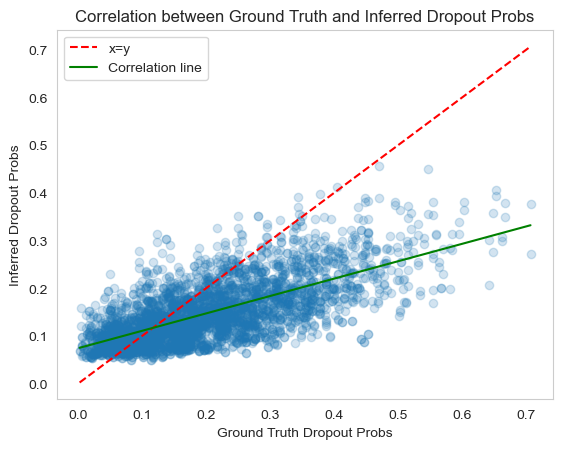

In [15]:
keep_indices = np.array([i for i in range(total_rounds*n_samples) if i % total_rounds != 0])
h_counts = np.sum(np.array(all_individual_genotypes)[keep_indices,0] == "H", axis=1)
mask = h_counts > 50
indices = mask.flatten()
x = np.array(all_individual_params)[keep_indices, 1].flatten()[indices] # gt
y = np.array(all_individual_params)[keep_indices, 0].flatten()[indices] # predicted

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Probs")
plt.ylabel("Inferred Dropout Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Probs")
plt.legend()
plt.show()

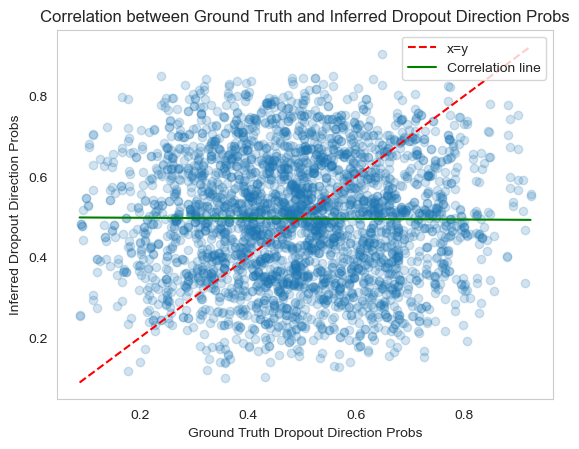

In [16]:
x = np.array(all_individual_params)[keep_indices, 3].flatten()[indices] # gt
y = np.array(all_individual_params)[keep_indices, 2].flatten()[indices] # predicted

plt.scatter(x, y, alpha=0.2)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Dropout Direction Probs")
plt.ylabel("Inferred Dropout Direction Probs")
plt.title("Correlation between Ground Truth and Inferred Dropout Direction Probs")
plt.legend()
plt.show()

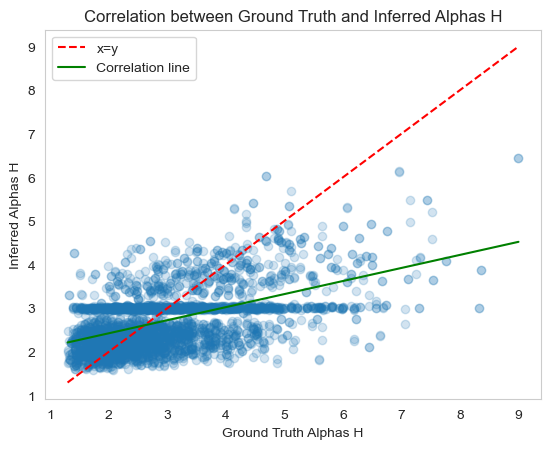

In [17]:
x_alpha = np.array(all_individual_params)[keep_indices, 5].flatten()[indices] # gt
y_alpha = np.array(all_individual_params)[keep_indices, 4].flatten()[indices] # predicted

plt.scatter(x_alpha, y_alpha, alpha=0.2)
lims = [min(x_alpha.min(), y_alpha.min()), max(x_alpha.max(), y_alpha.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x_alpha, y_alpha, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Alphas H")
plt.ylabel("Inferred Alphas H")
plt.title("Correlation between Ground Truth and Inferred Alphas H")
plt.legend()
plt.show()

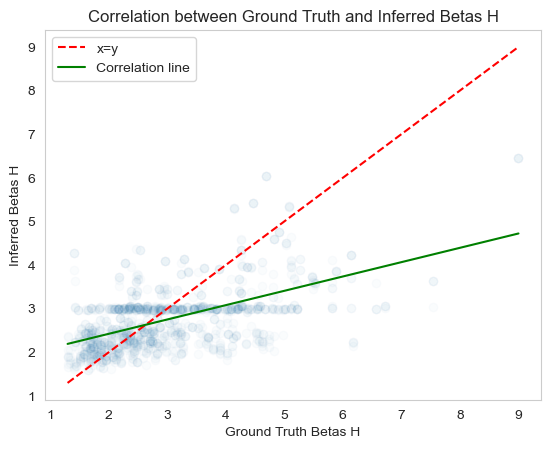

In [6]:
x_beta = np.array(all_individual_params)[keep_indices, 7].flatten()[indices] # gt
y_beta = np.array(all_individual_params)[keep_indices, 6].flatten()[indices] # predicted

plt.scatter(x_beta, y_beta, alpha=0.02)
lims = [min(x_beta.min(), y_beta.min()), max(x_beta.max(), y_beta.max())]
plt.plot(lims, lims, 'r--', label='x=y')

m, b = np.polyfit(x_beta, y_beta, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
y_fit = m * x_fit + b
plt.plot(x_fit, y_fit, 'g-', label='Correlation line')

plt.grid(False)
plt.xlabel("Ground Truth Betas H")
plt.ylabel("Inferred Betas H")
plt.title("Correlation between Ground Truth and Inferred Betas H")
plt.legend()
plt.show()

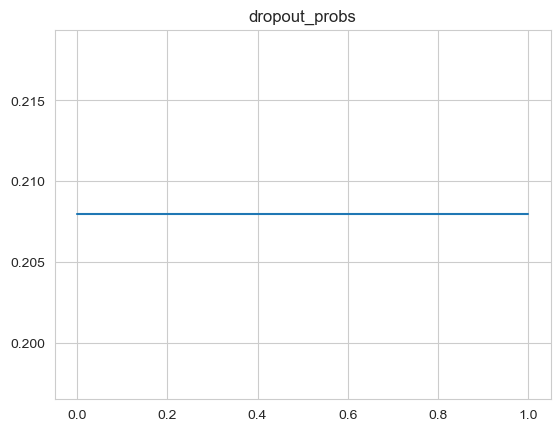

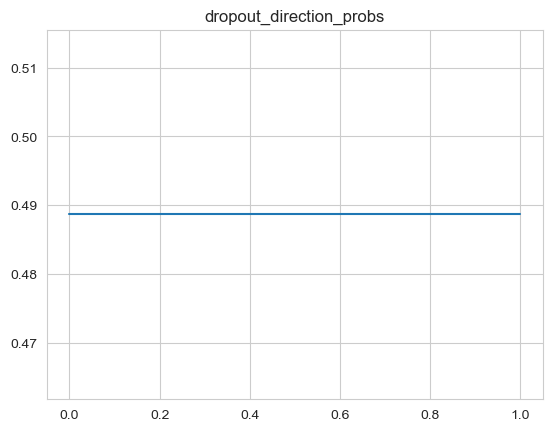

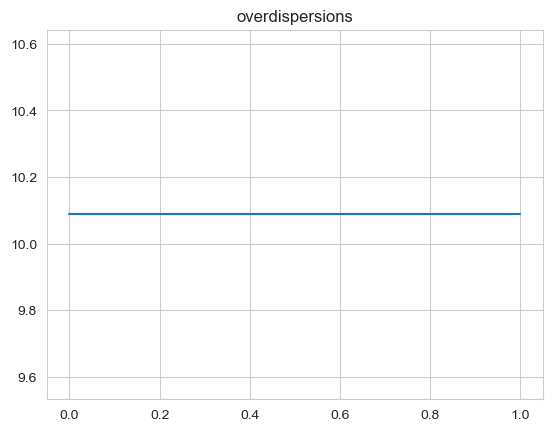

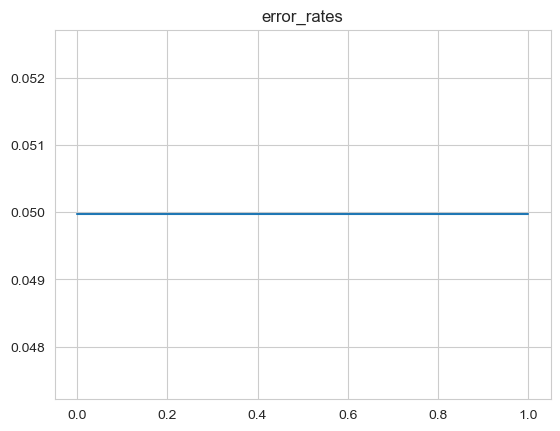

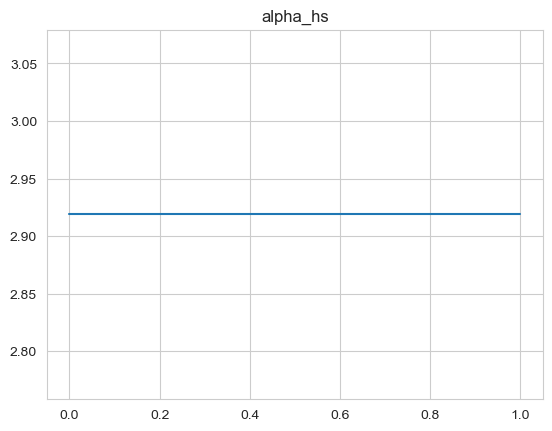

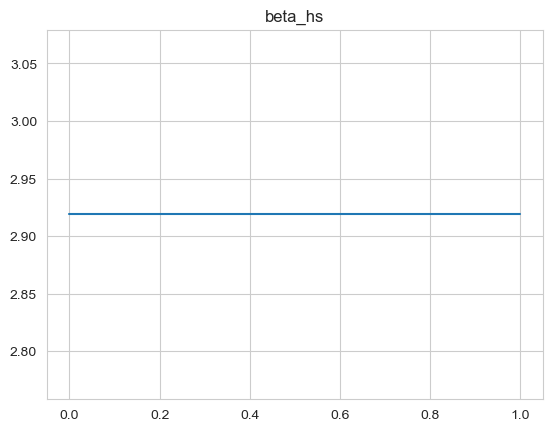

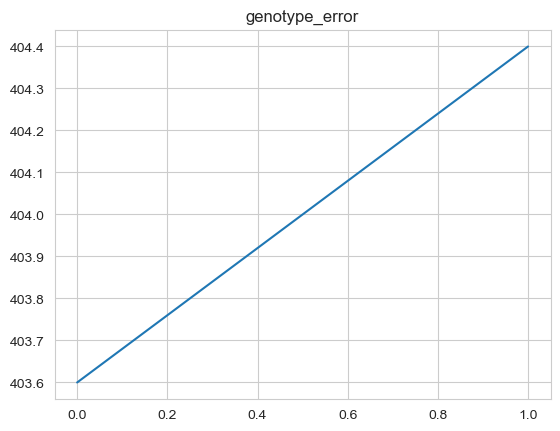

In [13]:
param = ["dropout_probs", "dropout_direction_probs", "overdispersions", "error_rates", "alpha_hs", "beta_hs", "genotype_error"]
for i in range(len(np.mean(all_params, axis=0)[0])):
    plt.title(param[i])
    plt.plot(np.mean(np.array(all_params), axis=0)[:,i])
    plt.show()

In [12]:
def genotype_confusion_matrix(genotype, genotype_gt):
    unique_genotypes = ["R", "H", "A"]
    confusion_counts = {g: {other: 0 for other in unique_genotypes} for g in unique_genotypes}

    for true, pred in zip(genotype_gt.flatten(), genotype.flatten()):
        if true != pred:
            confusion_counts[true][pred] += 1  # Count how often true genotype is mistaken for pred

    # Print results
    print("Replacements:")
    for true, counts in confusion_counts.items():
        for pred, count in counts.items():
            if true != pred:  # Only show misclassifications
                print(f"{true} → {pred}: {count}")

genotype_confusion_matrix(genotype_gt, genotype)

Replacements:
R → H: 217
R → A: 383
H → R: 278
H → A: 112
A → R: 769
A → H: 971


In [11]:
i=2
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\500c50m"

alt = np.loadtxt(os.path.join(path, "alt", 'alt_%i.txt' % i)).T
ref = np.loadtxt(os.path.join(path, "ref", 'ref_%i.txt' % i)).T
genotype_gt = np.loadtxt((os.path.join(path, "genotype", "genotype_%i.txt" % i)), dtype = str).T
dropout_probs_gt = np.loadtxt((os.path.join(path, "dropout_probs", "dropout_probs_%i.txt" % i)))
dropout_directions_gt = np.loadtxt((os.path.join(path, "dropout_directions", "dropout_directions_%i.txt" % i)))
alphas_H_gt = np.loadtxt((os.path.join(path, "alphas_H", "alphas_H_%i.txt" % i)))
betas_H_gt = np.loadtxt((os.path.join(path, "betas_H", "betas_H_%i.txt" % i)))
params = mf.update_parameters(np.array(ref), np.array(alt), np.array(genotype_gt))
dropout_probs, dropout_direction_probs, overdispersions, error_rates, alpha_hs, beta_hs, individual_dropout_probs, individual_dropout_direction_probs, individual_alphas_h, individual_betas_h = params

optimized:  23226.52048298504
ground truth:  23242.62323439122
Global parameters: [ 0.22689196  0.46977098 10.10182335  0.05121476  5.33750334]
